## Training (Text-SA)

In [ ]:
pip install torchnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 69.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 8.3 MB/s eta 0:00:00
  Created wheel for torchnet: filename=torchnet-0.0.4-py3-none-any.whl size=29743 sha256=349b3a351246b5225eb02661c634edacc4ef63c2a0a4a263832f29cf8df20039
  Stored in directory: /root/.cache/pip/wheels/65/d2/1e/0c2519d1837089fe374a60ce10e120c555b9d77110a49f027f
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=5b627031c686c4423e42dfe4dd89770e9e1b5c414f41d305e54075be5d94ae75
  Stored in directory: /root/.cache/pip/wheels/58/9e/14/30f7cc4dafdd4d602fb00ca33c6edd1424fc0f5df10a02e060
Successfully built torchnet visdom


In [ ]:
import json
import pickle
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torchnet.dataset import TensorDataset
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau

from sklearn.metrics import f1_score, accuracy_score, matthews_corrcoef, confusion_matrix

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/FML Project') 

## Set Device

In [ ]:
# set device
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available.")
else:
    device = torch.device("cpu")
    print("Using CPU.")

GPU is available.


## Load Features and Labels

In [ ]:
label_path = sys.path[-1]+"/Data/labels.npy"
text_path = sys.path[-1]+"/Data/text_features_256.pt"
image_path = sys.path[-1]+"/Data/image_features.pt"

In [ ]:
labels = np.load(label_path)
print('Labels loaded!')

Labels loaded!


In [ ]:
text_features = torch.load(text_path)
print('Text features loaded!')

Text features loaded!


## Split Data

In [ ]:
df = pd.read_csv(sys.path[-1]+"/Data/df_final.csv")
train_ids = list(df[df['target_date'] < '2015-08-01'].index)
valid_ids = list(df[df['target_date'].between('2015-08-01','2015-10-01')].index)
test_ids = list(df[df['target_date'] > '2015-10-01'].index)
print(len(train_ids), len(valid_ids), len(test_ids))

14040 1910 2593


In [ ]:
dataset = TensorDataset([text_features.float(), torch.tensor(labels).float()])

train_set = TensorDataset([torch.utils.data.Subset(dataset, train_ids)])
valid_set = TensorDataset([torch.utils.data.Subset(dataset, valid_ids)])
test_set = TensorDataset([torch.utils.data.Subset(dataset, test_ids)])

train_loader = DataLoader(train_set, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_set, batch_size=128, shuffle=False)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False)

print('Datasets ready!')

Datasets ready!


## Evaluation Metrics

In [ ]:
def compute_accuracy(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return accuracy_score(np.array(y_true), np.array(y_pred))

def compute_f1(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return f1_score(np.array(y_true), np.array(y_pred))

def compute_MCC(y_true, y_pred):
    assert (len(y_true) == len(y_pred))
    return matthews_corrcoef(np.array(y_true), np.array(y_pred))

def evaluate_metrics(preds, labels):
    labels = [int(item) for item in labels]
    preds = [0 if item < 0.5 else 1 for item in preds]
    accuracy = compute_accuracy(labels, preds)
    f1 = compute_f1(labels, preds)
    mcc = compute_MCC(labels, preds)
    cm = confusion_matrix(labels, preds)
    return accuracy, f1, mcc, cm

## Training

In [ ]:
def save_model(model, name):
    torch.save(model.state_dict(), name)

def load_model(model, name):
    weights = torch.load(name)
    model.load_state_dict(weights)
    return model

In [ ]:
def train_model(model, params, train_loader, valid_loader, test_loader, report_loss=True):

    device = params['device']
    n_epochs = params['n_epochs']
    criterion = params['criterion']
    optimizer = params['optimizer']
    scheduler = params['scheduler']

    stop = 0
    best_valid_mcc = -1

    valid_metrics = {}
    test_metrics = {}
    train_loss, valid_loss, test_loss = [], [], []
    valid_a, valid_f1, valid_mcc, valid_cm = [], [], [], []
    test_a, test_f1, test_mcc, test_cm = [], [], [], []

    f = nn.Sigmoid()

    for epoch in range(n_epochs):

        train_loss_i, batch, total = 0.0, 0, 0
        model.train()
        for data in tqdm(train_loader):
            if params['model_type'] == 'unimodal':
                x, labels = data[0][0].to(device), data[0][1].to(device)
                preds = model(x)
            elif params['model_type'] == 'bimodal':
                x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                preds = model(x_txt, x_img)
            preds = f(preds).squeeze()
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss_i += loss.item()
            batch += 1
            total += labels.shape[0]
            if report_loss and batch%200==0:
                print("Batch: {}, Training Loss: {:.4f}".format(batch, train_loss_i/total))
        train_loss_i = train_loss_i / len(train_loader.dataset)

        valid_loss_i = 0.0
        valid_preds, valid_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(valid_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                valid_loss_i += loss.item()
                valid_preds.append(preds)
                valid_labels.append(labels)
        valid_loss_i = valid_loss_i / len(valid_loader.dataset)
        valid_preds = torch.cat(valid_preds)
        valid_labels = torch.cat(valid_labels)

        valid_a_i, valid_f1_i, valid_mcc_i, valid_cm_i = evaluate_metrics(valid_preds, valid_labels)

        test_loss_i = 0.0
        test_preds, test_labels= [], []
        model.eval()
        with torch.no_grad():
            for data in tqdm(test_loader):
                if params['model_type'] == 'unimodal':
                    x, labels = data[0][0].to(device), data[0][1].to(device)
                    preds = model(x)
                elif params['model_type'] == 'bimodal':
                    x_txt, x_img, labels = data[0][0].to(device), data[0][1].to(device), data[0][2].to(device)
                    preds = model(x_txt, x_img)
                preds = f(preds).squeeze()
                loss = criterion(preds, labels)
                test_loss_i += loss.item()
                test_preds.append(preds)
                test_labels.append(labels)
        test_loss_i = test_loss_i / len(test_loader.dataset)
        test_preds = torch.cat(test_preds)
        test_labels = torch.cat(test_labels)

        test_a_i, test_f1_i, test_mcc_i, test_cm_i = evaluate_metrics(test_preds, test_labels)

        scheduler.step(valid_loss_i)  # decay learning rate by validation loss

        if valid_mcc_i > best_valid_mcc:
            save_model(model, sys.path[-1]+'/Models/'+params['model_name']+'.pt')
            print("Saved model at epoch {} with validation MCC score of {:.4f}%".format(epoch+1, valid_mcc_i))
            best_valid_mcc = valid_mcc_i

        if report_loss:
            print("\n")
            print("-" * 50)
            print("Epoch ", epoch+1)
            print("Training Loss: {:.4f}, Validation Loss: {:.4f}".format(train_loss_i, valid_loss_i))
            print('Validation Results: ')
            print("Accuracy: {:.4f}".format(valid_a_i))
            print("F1 Score: {:.4f}".format(valid_f1_i))
            print("MCC Score: {:.4f}".format(valid_mcc_i))
            print('Test Results: ')
            print("Accuracy: {:.4f}".format(test_a_i))
            print("F1 Score: {:.4f}".format(test_f1_i))
            print("MCC Score: {:.4f}".format(test_mcc_i))
            print("-" * 50)
            print("\n")
        
        train_loss.append(train_loss_i)
        valid_loss.append(valid_loss_i)
        test_loss.append(test_loss_i)

        valid_a.append(valid_a_i)
        valid_f1.append(valid_f1_i)
        valid_mcc.append(valid_mcc_i)
        valid_cm.append(valid_cm_i)

        test_a.append(test_a_i)
        test_f1.append(test_f1_i)
        test_mcc.append(test_mcc_i)
        test_cm.append(test_cm_i)


        if len(valid_loss) > 0:  
            if valid_loss_i <= valid_loss[-1]:
                stop = 0
            else:
                stop += 1
                if stop >= int(params['n_stop']):   # stop training when no improvement observed in consecutive epoches
                    print("Early stopped. No improvement in validation loss for params['n_stop'] consecutive epoches.")
                    break

    valid_metrics['acc'] = valid_a
    valid_metrics['f1'] = valid_f1
    valid_metrics['mcc'] = valid_mcc
    valid_metrics['cm'] = valid_cm

    test_metrics['acc'] = test_a
    test_metrics['f1'] = test_f1
    test_metrics['mcc'] = test_mcc
    test_metrics['cm'] = test_cm

    return train_loss, valid_loss, test_loss, valid_metrics, test_metrics

## Models

In [ ]:
class Text_SA(nn.Module):
    """
    Unimodal (text) classifier based on self-supervised embeddings and self-attention.
    """
    def __init__(self, params):
        super(Text_SA, self).__init__()
        # functional layers
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=params['txt_dropout'])
        # multi-heads self-attention
        self.mha = nn.MultiheadAttention(embed_dim=params['hidden_size'],
                                         num_heads=params['txt_H'],
                                         dropout=params['txt_dropout'],
                                         batch_first=True)
        # fully connected layers
        self.reduce_dim = nn.Linear(in_features=params['txt_embed_size'],
                                    out_features=params['hidden_size'])
        self.classifier = nn.Linear(in_features=params['hidden_size'],
                                    out_features=1)

    def forward(self, x_txt):
        """
        Input:
            x_txt   | text self-supervised embeddings, shape = (batch_size, txt_embedding_size)
        Output:
            y       | unnormalized logits, shape = (batch_size, 1)
        """
        # dimension reduction
        x_txt = self.relu(self.reduce_dim(x_txt))
        # dropout
        x_txt = self.dropout(x_txt)
        # self-attention
        x_txt, _ = self.mha(x_txt, x_txt, x_txt)
        # temporal average as global representation
        x_txt = torch.mean(x_txt, dim=1)
        # classification
        y = self.classifier(x_txt)
        return y

## Unimodal

In [ ]:
model_params = {'txt_embed_size': 768,
                'img_embed_size': 2048,
                'hidden_size': 512,
                'txt_H': 4,
                'vt_H': 4,
                'txt_dropout': 0.01,
                'img_dropout': 0.01,
                'vt_dropout': 0.01,
                'transformer_dropout': 0.01}  

best_acc, best_f1, best_mcc, best_cm = [], [], [], []

for i in range(5):

    model = Text_SA(model_params)
    model.to(device)
    criterion = nn.BCELoss()    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.1, verbose=True)
    train_params = {'n_epochs': 30,
                    'criterion': criterion,
                    'optimizer': optimizer,
                    'scheduler': scheduler,
                    'n_stop': 8,
                    'model_name': 'Text_SA',
                    'model_type': 'unimodal',
                    'device': device}

    train_loss, valid_loss, test_loss, valid_metrics, test_metrics = train_model(model, train_params, train_loader, valid_loader, test_loader)
        
    idx = np.argmax(test_metrics['mcc'])
    best_acc.append(test_metrics['acc'][idx])
    best_f1.append(test_metrics['f1'][idx])
    best_mcc.append(test_metrics['mcc'][idx])
    best_cm.append(test_metrics['cm'][idx])

    with open(sys.path[-1]+f"/Training Results/train_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(train_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_loss, f)
    with open(sys.path[-1]+f"/Training Results/test_loss_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_loss, f)
    with open(sys.path[-1]+f"/Training Results/valid_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(valid_metrics, f)
    with open(sys.path[-1]+f"/Training Results/test_metrics_{train_params['model_name']}_0{i+1}.pkl", 'wb') as f:
        pickle.dump(test_metrics, f)

 25%|██▌       | 222/878 [00:05<00:05, 120.37it/s]

Batch: 200, Training Loss: 0.0434


 48%|████▊     | 419/878 [00:06<00:03, 127.95it/s]

Batch: 400, Training Loss: 0.0434


 71%|███████   | 624/878 [00:08<00:01, 128.05it/s]

Batch: 600, Training Loss: 0.0434


 94%|█████████▍| 825/878 [00:09<00:00, 132.03it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:01<00:00, 20.76it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:05, 126.74it/s]

Batch: 200, Training Loss: 0.0433


 47%|████▋     | 417/878 [00:03<00:03, 124.48it/s]

Batch: 400, Training Loss: 0.0433


 71%|███████   | 619/878 [00:04<00:01, 130.49it/s]

Batch: 600, Training Loss: 0.0433


 94%|█████████▎| 821/878 [00:06<00:00, 127.00it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 19.63it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4628
F1 Score: 0.5664
MCC Score: -0.0267
Test Results: 
Accuracy: 0.5187
F1 Score: 0.6387
MCC Score: 0.0087
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:05, 126.65it/s]

Batch: 200, Training Loss: 0.0433


 48%|████▊     | 424/878 [00:03<00:03, 127.86it/s]

Batch: 400, Training Loss: 0.0433


 71%|███████   | 619/878 [00:04<00:02, 122.70it/s]

Batch: 600, Training Loss: 0.0433


 93%|█████████▎| 814/878 [00:06<00:00, 123.26it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 20.03it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4565
F1 Score: 0.6074
MCC Score: -0.0150
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6760
MCC Score: 0.0124
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 127.91it/s]

Batch: 200, Training Loss: 0.0431


 48%|████▊     | 421/878 [00:03<00:03, 128.18it/s]

Batch: 400, Training Loss: 0.0431


 70%|███████   | 616/878 [00:04<00:02, 126.28it/s]

Batch: 600, Training Loss: 0.0432


 93%|█████████▎| 813/878 [00:06<00:00, 128.13it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:01<00:00, 19.68it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0432, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4613
F1 Score: 0.6068
MCC Score: -0.0014
Test Results: 
Accuracy: 0.5160
F1 Score: 0.6691
MCC Score: -0.0240
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 127.41it/s]

Batch: 200, Training Loss: 0.0428


 48%|████▊     | 420/878 [00:03<00:03, 132.05it/s]

Batch: 400, Training Loss: 0.0429


 71%|███████   | 624/878 [00:04<00:01, 129.00it/s]

Batch: 600, Training Loss: 0.0428


 94%|█████████▎| 823/878 [00:06<00:00, 129.44it/s]

Batch: 800, Training Loss: 0.0428


100%|██████████| 21/21 [00:01<00:00, 20.05it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0428, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.5720
MCC Score: -0.0431
Test Results: 
Accuracy: 0.5044
F1 Score: 0.6365
MCC Score: -0.0337
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 129.26it/s]

Batch: 200, Training Loss: 0.0423


 47%|████▋     | 413/878 [00:03<00:03, 126.69it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 622/878 [00:04<00:02, 127.87it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 825/878 [00:06<00:00, 129.24it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:01<00:00, 20.01it/s]


Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  6
Training Loss: 0.0422, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4785
F1 Score: 0.5094
MCC Score: -0.0235
Test Results: 
Accuracy: 0.4940
F1 Score: 0.5556
MCC Score: -0.0239
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 126.57it/s]

Batch: 200, Training Loss: 0.0410


 48%|████▊     | 419/878 [00:03<00:03, 127.86it/s]

Batch: 400, Training Loss: 0.0408


 71%|███████   | 619/878 [00:04<00:01, 130.57it/s]

Batch: 600, Training Loss: 0.0407


 93%|█████████▎| 817/878 [00:06<00:00, 127.44it/s]

Batch: 800, Training Loss: 0.0405


100%|██████████| 21/21 [00:01<00:00, 19.59it/s]


Saved model at epoch 7 with validation MCC score of 0.0053%


--------------------------------------------------
Epoch  7
Training Loss: 0.0405, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.4456
MCC Score: 0.0053
Test Results: 
Accuracy: 0.4979
F1 Score: 0.4716
MCC Score: 0.0032
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 126.02it/s]

Batch: 200, Training Loss: 0.0398


 49%|████▊     | 426/878 [00:03<00:03, 129.74it/s]

Batch: 400, Training Loss: 0.0397


 70%|███████   | 615/878 [00:04<00:02, 129.51it/s]

Batch: 600, Training Loss: 0.0397


 93%|█████████▎| 818/878 [00:06<00:00, 129.08it/s]

Batch: 800, Training Loss: 0.0398


100%|██████████| 21/21 [00:01<00:00, 20.23it/s]


Saved model at epoch 8 with validation MCC score of 0.0106%


--------------------------------------------------
Epoch  8
Training Loss: 0.0398, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.5283
MCC Score: 0.0106
Test Results: 
Accuracy: 0.4956
F1 Score: 0.5620
MCC Score: -0.0222
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 124.69it/s]

Batch: 200, Training Loss: 0.0391


 47%|████▋     | 416/878 [00:03<00:03, 123.83it/s]

Batch: 400, Training Loss: 0.0392


 70%|███████   | 615/878 [00:04<00:02, 129.51it/s]

Batch: 600, Training Loss: 0.0391


 94%|█████████▎| 821/878 [00:06<00:00, 130.34it/s]

Batch: 800, Training Loss: 0.0391


100%|██████████| 21/21 [00:01<00:00, 20.33it/s]


Saved model at epoch 9 with validation MCC score of 0.0319%


--------------------------------------------------
Epoch  9
Training Loss: 0.0392, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5141
F1 Score: 0.5005
MCC Score: 0.0319
Test Results: 
Accuracy: 0.4890
F1 Score: 0.4987
MCC Score: -0.0215
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 131.06it/s]

Batch: 200, Training Loss: 0.0386


 47%|████▋     | 417/878 [00:03<00:03, 130.48it/s]

Batch: 400, Training Loss: 0.0386


 70%|██████▉   | 613/878 [00:04<00:02, 125.73it/s]

Batch: 600, Training Loss: 0.0386


 94%|█████████▎| 821/878 [00:06<00:00, 126.85it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.79it/s]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  10
Training Loss: 0.0387, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5120
F1 Score: 0.4668
MCC Score: 0.0171
Test Results: 
Accuracy: 0.4871
F1 Score: 0.4567
MCC Score: -0.0181
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 130.78it/s]

Batch: 200, Training Loss: 0.0381


 48%|████▊     | 420/878 [00:03<00:03, 131.41it/s]

Batch: 400, Training Loss: 0.0382


 70%|██████▉   | 614/878 [00:04<00:02, 123.69it/s]

Batch: 600, Training Loss: 0.0381


 94%|█████████▍| 826/878 [00:06<00:00, 129.52it/s]

Batch: 800, Training Loss: 0.0381


100%|██████████| 21/21 [00:01<00:00, 19.76it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0381, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5126
F1 Score: 0.4959
MCC Score: 0.0277
Test Results: 
Accuracy: 0.4894
F1 Score: 0.4931
MCC Score: -0.0195
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 130.13it/s]

Batch: 200, Training Loss: 0.0384


 47%|████▋     | 417/878 [00:03<00:03, 126.82it/s]

Batch: 400, Training Loss: 0.0381


 71%|███████   | 620/878 [00:04<00:01, 131.38it/s]

Batch: 600, Training Loss: 0.0380


 94%|█████████▎| 823/878 [00:06<00:00, 128.46it/s]

Batch: 800, Training Loss: 0.0381


100%|██████████| 21/21 [00:01<00:00, 19.46it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0380, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5084
F1 Score: 0.4922
MCC Score: 0.0194
Test Results: 
Accuracy: 0.4902
F1 Score: 0.4927
MCC Score: -0.0177
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 127.83it/s]

Batch: 200, Training Loss: 0.0383


 48%|████▊     | 422/878 [00:03<00:03, 119.94it/s]

Batch: 400, Training Loss: 0.0380


 71%|███████   | 623/878 [00:04<00:01, 131.64it/s]

Batch: 600, Training Loss: 0.0382


 94%|█████████▍| 824/878 [00:06<00:00, 128.20it/s]

Batch: 800, Training Loss: 0.0380


100%|██████████| 21/21 [00:01<00:00, 20.24it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0380, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5126
F1 Score: 0.4915
MCC Score: 0.0261
Test Results: 
Accuracy: 0.4886
F1 Score: 0.4868
MCC Score: -0.0200
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:05, 127.80it/s]

Batch: 200, Training Loss: 0.0386


 48%|████▊     | 420/878 [00:03<00:03, 130.68it/s]

Batch: 400, Training Loss: 0.0380


 70%|██████▉   | 614/878 [00:04<00:02, 128.59it/s]

Batch: 600, Training Loss: 0.0380


 94%|█████████▎| 823/878 [00:06<00:00, 126.30it/s]

Batch: 800, Training Loss: 0.0379


100%|██████████| 21/21 [00:01<00:00, 19.94it/s]


Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  14
Training Loss: 0.0379, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4983
MCC Score: -0.0163
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:05, 129.25it/s]

Batch: 200, Training Loss: 0.0383


 47%|████▋     | 414/878 [00:03<00:03, 127.54it/s]

Batch: 400, Training Loss: 0.0380


 70%|███████   | 616/878 [00:04<00:01, 131.01it/s]

Batch: 600, Training Loss: 0.0379


 94%|█████████▍| 824/878 [00:06<00:00, 128.06it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.55it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0379, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4983
MCC Score: -0.0163
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 121.01it/s]

Batch: 200, Training Loss: 0.0378


 47%|████▋     | 416/878 [00:03<00:03, 128.92it/s]

Batch: 400, Training Loss: 0.0379


 71%|███████   | 621/878 [00:04<00:01, 129.12it/s]

Batch: 600, Training Loss: 0.0378


 93%|█████████▎| 817/878 [00:06<00:00, 128.69it/s]

Batch: 800, Training Loss: 0.0379


100%|██████████| 21/21 [00:01<00:00, 19.93it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0379, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4983
MCC Score: -0.0163
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 123.09it/s]

Batch: 200, Training Loss: 0.0375


 47%|████▋     | 414/878 [00:03<00:03, 129.79it/s]

Batch: 400, Training Loss: 0.0376


 71%|███████   | 622/878 [00:04<00:02, 125.88it/s]

Batch: 600, Training Loss: 0.0378


 94%|█████████▎| 822/878 [00:06<00:00, 129.66it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0379, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4979
MCC Score: -0.0162
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 130.71it/s]

Batch: 200, Training Loss: 0.0378


 49%|████▊     | 426/878 [00:03<00:03, 130.67it/s]

Batch: 400, Training Loss: 0.0380


 71%|███████   | 619/878 [00:04<00:02, 128.40it/s]

Batch: 600, Training Loss: 0.0380


 94%|█████████▎| 823/878 [00:06<00:00, 131.51it/s]

Batch: 800, Training Loss: 0.0379


100%|██████████| 21/21 [00:01<00:00, 19.32it/s]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  18
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4973
MCC Score: -0.0169
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 126.41it/s]

Batch: 200, Training Loss: 0.0380


 48%|████▊     | 418/878 [00:03<00:03, 128.53it/s]

Batch: 400, Training Loss: 0.0380


 71%|███████   | 622/878 [00:04<00:02, 126.09it/s]

Batch: 600, Training Loss: 0.0378


 94%|█████████▍| 825/878 [00:06<00:00, 128.43it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 20.05it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4973
MCC Score: -0.0169
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 127.19it/s]

Batch: 200, Training Loss: 0.0378


 48%|████▊     | 422/878 [00:03<00:03, 123.55it/s]

Batch: 400, Training Loss: 0.0378


 70%|██████▉   | 614/878 [00:04<00:01, 132.01it/s]

Batch: 600, Training Loss: 0.0380


 94%|█████████▎| 821/878 [00:06<00:00, 126.22it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 20.17it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0379, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4973
MCC Score: -0.0169
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 130.22it/s]

Batch: 200, Training Loss: 0.0378


 47%|████▋     | 416/878 [00:03<00:03, 126.81it/s]

Batch: 400, Training Loss: 0.0378


 71%|███████   | 624/878 [00:04<00:01, 128.18it/s]

Batch: 600, Training Loss: 0.0379


 93%|█████████▎| 819/878 [00:06<00:00, 122.42it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.51it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4973
MCC Score: -0.0169
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 131.28it/s]

Batch: 200, Training Loss: 0.0378


 48%|████▊     | 422/878 [00:03<00:03, 127.79it/s]

Batch: 400, Training Loss: 0.0379


 70%|██████▉   | 614/878 [00:04<00:02, 127.51it/s]

Batch: 600, Training Loss: 0.0379


 93%|█████████▎| 814/878 [00:06<00:00, 129.27it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.58it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4973
MCC Score: -0.0169
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 125.28it/s]

Batch: 200, Training Loss: 0.0375


 48%|████▊     | 422/878 [00:03<00:03, 132.33it/s]

Batch: 400, Training Loss: 0.0378


 71%|███████   | 625/878 [00:04<00:01, 128.07it/s]

Batch: 600, Training Loss: 0.0378


 94%|█████████▎| 821/878 [00:06<00:00, 129.55it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 20.42it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4973
MCC Score: -0.0169
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 126.29it/s]

Batch: 200, Training Loss: 0.0383


 48%|████▊     | 421/878 [00:03<00:03, 126.28it/s]

Batch: 400, Training Loss: 0.0382


 70%|███████   | 616/878 [00:04<00:02, 124.42it/s]

Batch: 600, Training Loss: 0.0380


 93%|█████████▎| 817/878 [00:06<00:00, 127.73it/s]

Batch: 800, Training Loss: 0.0379


100%|██████████| 21/21 [00:01<00:00, 20.37it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4909
F1 Score: 0.4973
MCC Score: -0.0169
--------------------------------------------------




 24%|██▍       | 213/878 [00:01<00:05, 130.39it/s]

Batch: 200, Training Loss: 0.0379


 47%|████▋     | 416/878 [00:03<00:03, 128.73it/s]

Batch: 400, Training Loss: 0.0381


 71%|███████   | 621/878 [00:04<00:01, 129.46it/s]

Batch: 600, Training Loss: 0.0380


 93%|█████████▎| 814/878 [00:06<00:00, 124.10it/s]

Batch: 800, Training Loss: 0.0379


100%|██████████| 21/21 [00:01<00:00, 19.22it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4979
MCC Score: -0.0162
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 129.07it/s]

Batch: 200, Training Loss: 0.0375


 48%|████▊     | 424/878 [00:03<00:03, 127.73it/s]

Batch: 400, Training Loss: 0.0378


 70%|██████▉   | 613/878 [00:04<00:02, 128.63it/s]

Batch: 600, Training Loss: 0.0379


 94%|█████████▎| 823/878 [00:06<00:00, 129.70it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.48it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4979
MCC Score: -0.0162
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 125.33it/s]

Batch: 200, Training Loss: 0.0377


 47%|████▋     | 415/878 [00:03<00:03, 126.92it/s]

Batch: 400, Training Loss: 0.0379


 70%|██████▉   | 613/878 [00:04<00:02, 127.64it/s]

Batch: 600, Training Loss: 0.0378


 94%|█████████▍| 826/878 [00:06<00:00, 129.55it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 20.21it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4979
MCC Score: -0.0162
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 129.76it/s]

Batch: 200, Training Loss: 0.0379


 48%|████▊     | 421/878 [00:03<00:03, 129.84it/s]

Batch: 400, Training Loss: 0.0379


 70%|███████   | 617/878 [00:04<00:02, 124.31it/s]

Batch: 600, Training Loss: 0.0379


 94%|█████████▍| 825/878 [00:06<00:00, 124.56it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.93it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4979
MCC Score: -0.0162
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 127.45it/s]

Batch: 200, Training Loss: 0.0373


 48%|████▊     | 418/878 [00:03<00:03, 131.28it/s]

Batch: 400, Training Loss: 0.0374


 71%|███████   | 624/878 [00:04<00:01, 128.05it/s]

Batch: 600, Training Loss: 0.0377


 93%|█████████▎| 814/878 [00:06<00:00, 128.72it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.68it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4979
MCC Score: -0.0162
--------------------------------------------------




 24%|██▍       | 213/878 [00:01<00:05, 129.05it/s]

Batch: 200, Training Loss: 0.0379


 47%|████▋     | 413/878 [00:03<00:03, 127.61it/s]

Batch: 400, Training Loss: 0.0380


 70%|██████▉   | 614/878 [00:04<00:02, 124.98it/s]

Batch: 600, Training Loss: 0.0378


 93%|█████████▎| 820/878 [00:06<00:00, 133.81it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 20.50it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0378, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4911
MCC Score: 0.0173
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4979
MCC Score: -0.0162
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:04, 131.56it/s]

Batch: 200, Training Loss: 0.0435


 48%|████▊     | 419/878 [00:03<00:03, 121.83it/s]

Batch: 400, Training Loss: 0.0434


 70%|███████   | 615/878 [00:04<00:02, 123.82it/s]

Batch: 600, Training Loss: 0.0434


 94%|█████████▎| 822/878 [00:06<00:00, 129.92it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:01<00:00, 19.43it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:04, 132.36it/s]

Batch: 200, Training Loss: 0.0432


 47%|████▋     | 413/878 [00:03<00:03, 131.37it/s]

Batch: 400, Training Loss: 0.0433


 71%|███████   | 621/878 [00:04<00:01, 132.73it/s]

Batch: 600, Training Loss: 0.0433


 94%|█████████▎| 822/878 [00:06<00:00, 124.23it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 20.13it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4691
F1 Score: 0.4595
MCC Score: -0.0569
Test Results: 
Accuracy: 0.4809
F1 Score: 0.5179
MCC Score: -0.0436
--------------------------------------------------




 24%|██▍       | 213/878 [00:01<00:05, 130.78it/s]

Batch: 200, Training Loss: 0.0432


 48%|████▊     | 422/878 [00:03<00:03, 129.98it/s]

Batch: 400, Training Loss: 0.0432


 70%|██████▉   | 614/878 [00:04<00:01, 132.31it/s]

Batch: 600, Training Loss: 0.0432


 94%|█████████▍| 824/878 [00:06<00:00, 128.96it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:01<00:00, 20.36it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4592
F1 Score: 0.5951
MCC Score: -0.0176
Test Results: 
Accuracy: 0.5241
F1 Score: 0.6665
MCC Score: 0.0138
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 125.56it/s]

Batch: 200, Training Loss: 0.0431


 48%|████▊     | 420/878 [00:03<00:03, 128.36it/s]

Batch: 400, Training Loss: 0.0430


 71%|███████   | 625/878 [00:04<00:01, 127.10it/s]

Batch: 600, Training Loss: 0.0431


 93%|█████████▎| 820/878 [00:06<00:00, 131.17it/s]

Batch: 800, Training Loss: 0.0430


100%|██████████| 21/21 [00:01<00:00, 19.94it/s]


Saved model at epoch 4 with validation MCC score of 0.0053%


--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5220
MCC Score: 0.0053
Test Results: 
Accuracy: 0.5017
F1 Score: 0.5742
MCC Score: -0.0115
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 130.03it/s]

Batch: 200, Training Loss: 0.0426


 47%|████▋     | 417/878 [00:03<00:03, 129.38it/s]

Batch: 400, Training Loss: 0.0426


 71%|███████   | 625/878 [00:04<00:02, 123.88it/s]

Batch: 600, Training Loss: 0.0426


 94%|█████████▍| 825/878 [00:06<00:00, 127.54it/s]

Batch: 800, Training Loss: 0.0427


100%|██████████| 21/21 [00:01<00:00, 19.52it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0427, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4607
F1 Score: 0.5916
MCC Score: -0.0162
Test Results: 
Accuracy: 0.5260
F1 Score: 0.6589
MCC Score: 0.0231
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:04, 131.84it/s]

Batch: 200, Training Loss: 0.0423


 47%|████▋     | 415/878 [00:03<00:03, 131.35it/s]

Batch: 400, Training Loss: 0.0422


 70%|███████   | 618/878 [00:04<00:01, 131.46it/s]

Batch: 600, Training Loss: 0.0421


 93%|█████████▎| 813/878 [00:06<00:00, 128.64it/s]

Batch: 800, Training Loss: 0.0421


100%|██████████| 21/21 [00:01<00:00, 19.60it/s]


Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  6
Training Loss: 0.0422, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4654
F1 Score: 0.5878
MCC Score: -0.0082
Test Results: 
Accuracy: 0.5229
F1 Score: 0.6515
MCC Score: 0.0161
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 130.11it/s]

Batch: 200, Training Loss: 0.0413


 47%|████▋     | 417/878 [00:03<00:03, 133.33it/s]

Batch: 400, Training Loss: 0.0408


 71%|███████   | 620/878 [00:04<00:02, 124.54it/s]

Batch: 600, Training Loss: 0.0407


 94%|█████████▎| 823/878 [00:06<00:00, 130.04it/s]

Batch: 800, Training Loss: 0.0405


100%|██████████| 21/21 [00:01<00:00, 19.98it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0406, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4421
MCC Score: -0.0187
Test Results: 
Accuracy: 0.4952
F1 Score: 0.4828
MCC Score: -0.0048
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:05, 128.59it/s]

Batch: 200, Training Loss: 0.0398


 47%|████▋     | 417/878 [00:03<00:03, 124.18it/s]

Batch: 400, Training Loss: 0.0395


 70%|███████   | 618/878 [00:04<00:01, 130.86it/s]

Batch: 600, Training Loss: 0.0395


 94%|█████████▎| 823/878 [00:06<00:00, 130.34it/s]

Batch: 800, Training Loss: 0.0396


100%|██████████| 21/21 [00:01<00:00, 19.33it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0396, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4848
F1 Score: 0.5214
MCC Score: -0.0081
Test Results: 
Accuracy: 0.4987
F1 Score: 0.5661
MCC Score: -0.0163
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:04, 131.60it/s]

Batch: 200, Training Loss: 0.0393


 48%|████▊     | 422/878 [00:03<00:03, 131.44it/s]

Batch: 400, Training Loss: 0.0391


 70%|███████   | 615/878 [00:04<00:02, 127.64it/s]

Batch: 600, Training Loss: 0.0389


 94%|█████████▎| 823/878 [00:06<00:00, 124.89it/s]

Batch: 800, Training Loss: 0.0389


100%|██████████| 21/21 [00:01<00:00, 19.70it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0390, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.4830
MCC Score: -0.0010
Test Results: 
Accuracy: 0.4998
F1 Score: 0.5202
MCC Score: -0.0021
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 123.80it/s]

Batch: 200, Training Loss: 0.0386


 48%|████▊     | 425/878 [00:03<00:03, 131.37it/s]

Batch: 400, Training Loss: 0.0384


 70%|███████   | 615/878 [00:04<00:02, 128.28it/s]

Batch: 600, Training Loss: 0.0383


 93%|█████████▎| 813/878 [00:06<00:00, 131.31it/s]

Batch: 800, Training Loss: 0.0384


100%|██████████| 21/21 [00:01<00:00, 19.74it/s]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  10
Training Loss: 0.0385, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4995
F1 Score: 0.4741
MCC Score: -0.0014
Test Results: 
Accuracy: 0.4975
F1 Score: 0.5010
MCC Score: -0.0032
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 127.15it/s]

Batch: 200, Training Loss: 0.0377


 48%|████▊     | 419/878 [00:03<00:03, 127.53it/s]

Batch: 400, Training Loss: 0.0379


 70%|███████   | 618/878 [00:04<00:02, 129.30it/s]

Batch: 600, Training Loss: 0.0380


 94%|█████████▎| 823/878 [00:06<00:00, 130.94it/s]

Batch: 800, Training Loss: 0.0379


100%|██████████| 21/21 [00:01<00:00, 20.05it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0379, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.4882
MCC Score: 0.0017
Test Results: 
Accuracy: 0.4990
F1 Score: 0.5158
MCC Score: -0.0029
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:05, 128.69it/s]

Batch: 200, Training Loss: 0.0372


 47%|████▋     | 415/878 [00:03<00:03, 125.44it/s]

Batch: 400, Training Loss: 0.0376


 71%|███████   | 623/878 [00:04<00:02, 125.81it/s]

Batch: 600, Training Loss: 0.0377


 93%|█████████▎| 814/878 [00:06<00:00, 130.78it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 20.05it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0379, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4995
F1 Score: 0.4844
MCC Score: 0.0021
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5073
MCC Score: -0.0096
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 128.47it/s]

Batch: 200, Training Loss: 0.0381


 48%|████▊     | 424/878 [00:03<00:03, 129.70it/s]

Batch: 400, Training Loss: 0.0380


 70%|███████   | 616/878 [00:04<00:02, 125.05it/s]

Batch: 600, Training Loss: 0.0379


 93%|█████████▎| 820/878 [00:06<00:00, 126.56it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0378, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4813
MCC Score: 0.0018
Test Results: 
Accuracy: 0.4967
F1 Score: 0.5070
MCC Score: -0.0062
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:05, 124.29it/s]

Batch: 200, Training Loss: 0.0375


 48%|████▊     | 422/878 [00:03<00:03, 131.61it/s]

Batch: 400, Training Loss: 0.0381


 71%|███████   | 621/878 [00:04<00:02, 123.56it/s]

Batch: 600, Training Loss: 0.0378


 94%|█████████▍| 826/878 [00:06<00:00, 131.35it/s]

Batch: 800, Training Loss: 0.0378


100%|██████████| 21/21 [00:01<00:00, 20.26it/s]


Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.
Saved model at epoch 14 with validation MCC score of 0.0057%


--------------------------------------------------
Epoch  14
Training Loss: 0.0378, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4898
MCC Score: 0.0057
Test Results: 
Accuracy: 0.5017
F1 Score: 0.5168
MCC Score: 0.0028
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 125.38it/s]

Batch: 200, Training Loss: 0.0375


 48%|████▊     | 418/878 [00:03<00:03, 126.19it/s]

Batch: 400, Training Loss: 0.0376


 70%|███████   | 615/878 [00:04<00:02, 126.96it/s]

Batch: 600, Training Loss: 0.0375


 93%|█████████▎| 814/878 [00:06<00:00, 126.79it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.93it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0377, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4995
F1 Score: 0.4893
MCC Score: 0.0038
Test Results: 
Accuracy: 0.5010
F1 Score: 0.5164
MCC Score: 0.0012
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 130.14it/s]

Batch: 200, Training Loss: 0.0376


 48%|████▊     | 424/878 [00:03<00:03, 131.06it/s]

Batch: 400, Training Loss: 0.0376


 70%|███████   | 616/878 [00:04<00:02, 124.10it/s]

Batch: 600, Training Loss: 0.0376


 94%|█████████▍| 824/878 [00:06<00:00, 125.25it/s]

Batch: 800, Training Loss: 0.0376


100%|██████████| 21/21 [00:01<00:00, 20.02it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0377, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4901
MCC Score: 0.0049
Test Results: 
Accuracy: 0.5010
F1 Score: 0.5164
MCC Score: 0.0012
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 128.80it/s]

Batch: 200, Training Loss: 0.0379


 47%|████▋     | 413/878 [00:03<00:03, 129.96it/s]

Batch: 400, Training Loss: 0.0377


 70%|███████   | 616/878 [00:04<00:02, 126.71it/s]

Batch: 600, Training Loss: 0.0377


 93%|█████████▎| 816/878 [00:06<00:00, 130.81it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.33it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0377, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4984
F1 Score: 0.4893
MCC Score: 0.0021
Test Results: 
Accuracy: 0.5010
F1 Score: 0.5168
MCC Score: 0.0011
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 120.86it/s]

Batch: 200, Training Loss: 0.0378


 48%|████▊     | 423/878 [00:03<00:03, 130.05it/s]

Batch: 400, Training Loss: 0.0376


 71%|███████   | 625/878 [00:04<00:01, 129.43it/s]

Batch: 600, Training Loss: 0.0377


 94%|█████████▎| 821/878 [00:06<00:00, 132.77it/s]

Batch: 800, Training Loss: 0.0376


100%|██████████| 21/21 [00:01<00:00, 19.96it/s]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-08.
Saved model at epoch 18 with validation MCC score of 0.0071%


--------------------------------------------------
Epoch  18
Training Loss: 0.0377, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4936
MCC Score: 0.0071
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 131.55it/s]

Batch: 200, Training Loss: 0.0381


 47%|████▋     | 413/878 [00:03<00:03, 126.79it/s]

Batch: 400, Training Loss: 0.0375


 71%|███████   | 621/878 [00:04<00:02, 124.20it/s]

Batch: 600, Training Loss: 0.0379


 94%|█████████▎| 821/878 [00:06<00:00, 129.45it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.57it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0377, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4936
MCC Score: 0.0071
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 129.81it/s]

Batch: 200, Training Loss: 0.0376


 48%|████▊     | 425/878 [00:03<00:03, 127.55it/s]

Batch: 400, Training Loss: 0.0377


 71%|███████   | 623/878 [00:04<00:01, 127.70it/s]

Batch: 600, Training Loss: 0.0378


 93%|█████████▎| 813/878 [00:06<00:00, 128.36it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.72it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0377, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4936
MCC Score: 0.0071
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:04, 132.66it/s]

Batch: 200, Training Loss: 0.0377


 47%|████▋     | 414/878 [00:03<00:03, 126.23it/s]

Batch: 400, Training Loss: 0.0377


 71%|███████   | 623/878 [00:04<00:01, 131.29it/s]

Batch: 600, Training Loss: 0.0376


 93%|█████████▎| 815/878 [00:06<00:00, 127.66it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.45it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0377, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4936
MCC Score: 0.0071
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 123.66it/s]

Batch: 200, Training Loss: 0.0385


 47%|████▋     | 415/878 [00:03<00:03, 123.50it/s]

Batch: 400, Training Loss: 0.0376


 70%|██████▉   | 613/878 [00:04<00:02, 127.91it/s]

Batch: 600, Training Loss: 0.0376


 92%|█████████▏| 812/878 [00:06<00:00, 128.73it/s]

Batch: 800, Training Loss: 0.0376


100%|██████████| 21/21 [00:01<00:00, 19.89it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4936
MCC Score: 0.0071
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 128.27it/s]

Batch: 200, Training Loss: 0.0374


 47%|████▋     | 416/878 [00:03<00:03, 126.16it/s]

Batch: 400, Training Loss: 0.0374


 70%|██████▉   | 613/878 [00:04<00:02, 126.27it/s]

Batch: 600, Training Loss: 0.0375


 94%|█████████▎| 823/878 [00:06<00:00, 129.46it/s]

Batch: 800, Training Loss: 0.0376


100%|██████████| 21/21 [00:01<00:00, 19.21it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4934
MCC Score: 0.0061
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 128.04it/s]

Batch: 200, Training Loss: 0.0378


 47%|████▋     | 414/878 [00:03<00:03, 127.39it/s]

Batch: 400, Training Loss: 0.0380


 71%|███████   | 622/878 [00:04<00:01, 132.91it/s]

Batch: 600, Training Loss: 0.0377


 93%|█████████▎| 814/878 [00:06<00:00, 128.91it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.59it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4934
MCC Score: 0.0061
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 126.14it/s]

Batch: 200, Training Loss: 0.0378


 47%|████▋     | 415/878 [00:03<00:03, 128.79it/s]

Batch: 400, Training Loss: 0.0377


 70%|███████   | 615/878 [00:04<00:02, 127.80it/s]

Batch: 600, Training Loss: 0.0376


 93%|█████████▎| 820/878 [00:06<00:00, 127.34it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.46it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4934
MCC Score: 0.0061
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 130.09it/s]

Batch: 200, Training Loss: 0.0380


 47%|████▋     | 415/878 [00:03<00:03, 125.25it/s]

Batch: 400, Training Loss: 0.0379


 70%|██████▉   | 613/878 [00:04<00:02, 128.58it/s]

Batch: 600, Training Loss: 0.0378


 93%|█████████▎| 817/878 [00:06<00:00, 127.68it/s]

Batch: 800, Training Loss: 0.0376


100%|██████████| 21/21 [00:01<00:00, 19.08it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4934
MCC Score: 0.0061
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:05, 130.95it/s]

Batch: 200, Training Loss: 0.0377


 48%|████▊     | 418/878 [00:03<00:03, 130.60it/s]

Batch: 400, Training Loss: 0.0378


 71%|███████   | 621/878 [00:04<00:02, 127.70it/s]

Batch: 600, Training Loss: 0.0376


 93%|█████████▎| 817/878 [00:06<00:00, 125.86it/s]

Batch: 800, Training Loss: 0.0375


100%|██████████| 21/21 [00:01<00:00, 19.91it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4934
MCC Score: 0.0061
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 26%|██▌       | 227/878 [00:01<00:04, 132.90it/s]

Batch: 200, Training Loss: 0.0377


 48%|████▊     | 421/878 [00:03<00:03, 123.41it/s]

Batch: 400, Training Loss: 0.0376


 71%|███████   | 620/878 [00:04<00:02, 127.56it/s]

Batch: 600, Training Loss: 0.0376


 93%|█████████▎| 813/878 [00:06<00:00, 130.09it/s]

Batch: 800, Training Loss: 0.0376


100%|██████████| 21/21 [00:01<00:00, 19.09it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5000
F1 Score: 0.4934
MCC Score: 0.0061
Test Results: 
Accuracy: 0.5010
F1 Score: 0.5175
MCC Score: 0.0010
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 126.11it/s]

Batch: 200, Training Loss: 0.0381


 48%|████▊     | 425/878 [00:03<00:03, 130.55it/s]

Batch: 400, Training Loss: 0.0377


 71%|███████   | 622/878 [00:04<00:02, 127.50it/s]

Batch: 600, Training Loss: 0.0377


 93%|█████████▎| 815/878 [00:06<00:00, 129.72it/s]

Batch: 800, Training Loss: 0.0377


100%|██████████| 21/21 [00:01<00:00, 19.65it/s]


Saved model at epoch 29 with validation MCC score of 0.0073%


--------------------------------------------------
Epoch  29
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4942
MCC Score: 0.0073
Test Results: 
Accuracy: 0.5010
F1 Score: 0.5175
MCC Score: 0.0010
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 128.43it/s]

Batch: 200, Training Loss: 0.0378


 47%|████▋     | 416/878 [00:03<00:03, 128.64it/s]

Batch: 400, Training Loss: 0.0377


 71%|███████   | 625/878 [00:04<00:02, 125.27it/s]

Batch: 600, Training Loss: 0.0376


 94%|█████████▍| 824/878 [00:06<00:00, 129.61it/s]

Batch: 800, Training Loss: 0.0376


100%|██████████| 21/21 [00:01<00:00, 19.65it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0377, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5005
F1 Score: 0.4942
MCC Score: 0.0073
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5170
MCC Score: 0.0003
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:05, 129.12it/s]

Batch: 200, Training Loss: 0.0434


 49%|████▊     | 426/878 [00:03<00:03, 129.35it/s]

Batch: 400, Training Loss: 0.0434


 71%|███████   | 621/878 [00:04<00:02, 125.46it/s]

Batch: 600, Training Loss: 0.0434


 94%|█████████▍| 824/878 [00:06<00:00, 126.91it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:01<00:00, 19.17it/s]


Saved model at epoch 1 with validation MCC score of 0.0000%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6244
MCC Score: 0.0000
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6884
MCC Score: 0.0000
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 127.12it/s]

Batch: 200, Training Loss: 0.0433


 48%|████▊     | 421/878 [00:03<00:03, 132.53it/s]

Batch: 400, Training Loss: 0.0433


 71%|███████   | 623/878 [00:04<00:01, 129.28it/s]

Batch: 600, Training Loss: 0.0433


 94%|█████████▍| 824/878 [00:06<00:00, 129.71it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 19.80it/s]




--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4639
F1 Score: 0.4656
MCC Score: -0.0638
Test Results: 
Accuracy: 0.4886
F1 Score: 0.5377
MCC Score: -0.0313
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 123.65it/s]

Batch: 200, Training Loss: 0.0432


 48%|████▊     | 420/878 [00:03<00:03, 123.29it/s]

Batch: 400, Training Loss: 0.0433


 70%|██████▉   | 613/878 [00:04<00:02, 131.87it/s]

Batch: 600, Training Loss: 0.0433


 93%|█████████▎| 816/878 [00:06<00:00, 125.97it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 19.61it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4691
F1 Score: 0.4663
MCC Score: -0.0547
Test Results: 
Accuracy: 0.5083
F1 Score: 0.5688
MCC Score: 0.0052
--------------------------------------------------




 24%|██▍       | 213/878 [00:01<00:05, 126.32it/s]

Batch: 200, Training Loss: 0.0432


 48%|████▊     | 418/878 [00:03<00:03, 129.14it/s]

Batch: 400, Training Loss: 0.0432


 71%|███████   | 622/878 [00:04<00:02, 127.43it/s]

Batch: 600, Training Loss: 0.0432


 93%|█████████▎| 817/878 [00:06<00:00, 121.95it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:01<00:00, 19.86it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0432, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4990
F1 Score: 0.3814
MCC Score: -0.0300
Test Results: 
Accuracy: 0.4875
F1 Score: 0.4390
MCC Score: -0.0144
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 128.99it/s]

Batch: 200, Training Loss: 0.0429


 47%|████▋     | 416/878 [00:03<00:03, 131.78it/s]

Batch: 400, Training Loss: 0.0429


 71%|███████   | 623/878 [00:04<00:02, 127.49it/s]

Batch: 600, Training Loss: 0.0428


 94%|█████████▎| 821/878 [00:06<00:00, 129.00it/s]

Batch: 800, Training Loss: 0.0428


100%|██████████| 21/21 [00:01<00:00, 19.35it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0429, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4644
F1 Score: 0.5693
MCC Score: -0.0220
Test Results: 
Accuracy: 0.5210
F1 Score: 0.6441
MCC Score: 0.0132
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 127.92it/s]

Batch: 200, Training Loss: 0.0425


 47%|████▋     | 415/878 [00:03<00:03, 126.76it/s]

Batch: 400, Training Loss: 0.0426


 71%|███████   | 619/878 [00:04<00:01, 130.42it/s]

Batch: 600, Training Loss: 0.0425


 93%|█████████▎| 814/878 [00:06<00:00, 129.31it/s]

Batch: 800, Training Loss: 0.0424


100%|██████████| 21/21 [00:01<00:00, 19.91it/s]


Epoch 00006: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  6
Training Loss: 0.0424, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.4493
MCC Score: -0.0050
Test Results: 
Accuracy: 0.4983
F1 Score: 0.4856
MCC Score: 0.0015
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 128.68it/s]

Batch: 200, Training Loss: 0.0412


 48%|████▊     | 425/878 [00:03<00:03, 126.76it/s]

Batch: 400, Training Loss: 0.0412


 71%|███████   | 620/878 [00:04<00:02, 127.52it/s]

Batch: 600, Training Loss: 0.0411


 93%|█████████▎| 816/878 [00:06<00:00, 126.14it/s]

Batch: 800, Training Loss: 0.0410


100%|██████████| 21/21 [00:01<00:00, 19.35it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0410, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4453
MCC Score: -0.0177
Test Results: 
Accuracy: 0.4902
F1 Score: 0.4791
MCC Score: -0.0152
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 126.11it/s]

Batch: 200, Training Loss: 0.0403


 49%|████▊     | 426/878 [00:03<00:03, 128.04it/s]

Batch: 400, Training Loss: 0.0403


 71%|███████   | 622/878 [00:04<00:01, 130.30it/s]

Batch: 600, Training Loss: 0.0403


 94%|█████████▎| 821/878 [00:06<00:00, 124.34it/s]

Batch: 800, Training Loss: 0.0403


100%|██████████| 21/21 [00:01<00:00, 19.43it/s]




--------------------------------------------------
Epoch  8
Training Loss: 0.0403, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5089
F1 Score: 0.4048
MCC Score: -0.0062
Test Results: 
Accuracy: 0.4894
F1 Score: 0.4278
MCC Score: -0.0083
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 129.62it/s]

Batch: 200, Training Loss: 0.0396


 47%|████▋     | 415/878 [00:03<00:03, 128.64it/s]

Batch: 400, Training Loss: 0.0398


 71%|███████   | 621/878 [00:04<00:01, 129.42it/s]

Batch: 600, Training Loss: 0.0397


 93%|█████████▎| 814/878 [00:06<00:00, 128.88it/s]

Batch: 800, Training Loss: 0.0397


100%|██████████| 21/21 [00:01<00:00, 19.48it/s]




--------------------------------------------------
Epoch  9
Training Loss: 0.0398, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4890
F1 Score: 0.4225
MCC Score: -0.0352
Test Results: 
Accuracy: 0.4836
F1 Score: 0.4510
MCC Score: -0.0248
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 126.22it/s]

Batch: 200, Training Loss: 0.0395


 48%|████▊     | 420/878 [00:03<00:03, 126.97it/s]

Batch: 400, Training Loss: 0.0392


 71%|███████   | 623/878 [00:04<00:02, 124.32it/s]

Batch: 600, Training Loss: 0.0392


 93%|█████████▎| 815/878 [00:06<00:00, 129.11it/s]

Batch: 800, Training Loss: 0.0392


100%|██████████| 21/21 [00:01<00:00, 19.60it/s]


Epoch 00010: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  10
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.5068
F1 Score: 0.3819
MCC Score: -0.0160
Test Results: 
Accuracy: 0.4809
F1 Score: 0.3910
MCC Score: -0.0224
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:04, 130.88it/s]

Batch: 200, Training Loss: 0.0392


 48%|████▊     | 420/878 [00:03<00:03, 126.95it/s]

Batch: 400, Training Loss: 0.0389


 70%|███████   | 615/878 [00:04<00:02, 124.54it/s]

Batch: 600, Training Loss: 0.0388


 92%|█████████▏| 812/878 [00:06<00:00, 126.75it/s]

Batch: 800, Training Loss: 0.0389


100%|██████████| 21/21 [00:01<00:00, 19.70it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0389, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.4511
MCC Score: -0.0220
Test Results: 
Accuracy: 0.4929
F1 Score: 0.4829
MCC Score: -0.0099
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 130.68it/s]

Batch: 200, Training Loss: 0.0386


 48%|████▊     | 420/878 [00:03<00:03, 127.60it/s]

Batch: 400, Training Loss: 0.0389


 71%|███████   | 625/878 [00:04<00:01, 130.60it/s]

Batch: 600, Training Loss: 0.0389


 93%|█████████▎| 820/878 [00:06<00:00, 128.15it/s]

Batch: 800, Training Loss: 0.0388


100%|██████████| 21/21 [00:01<00:00, 19.21it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0388, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4921
F1 Score: 0.4605
MCC Score: -0.0181
Test Results: 
Accuracy: 0.5006
F1 Score: 0.5002
MCC Score: 0.0037
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:05, 126.86it/s]

Batch: 200, Training Loss: 0.0390


 48%|████▊     | 421/878 [00:03<00:03, 128.98it/s]

Batch: 400, Training Loss: 0.0388


 71%|███████   | 625/878 [00:04<00:01, 132.81it/s]

Batch: 600, Training Loss: 0.0386


 93%|█████████▎| 820/878 [00:06<00:00, 130.27it/s]

Batch: 800, Training Loss: 0.0387


100%|██████████| 21/21 [00:01<00:00, 19.62it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0388, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.4685
MCC Score: -0.0146
Test Results: 
Accuracy: 0.5021
F1 Score: 0.5086
MCC Score: 0.0054
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 123.10it/s]

Batch: 200, Training Loss: 0.0387


 47%|████▋     | 416/878 [00:03<00:03, 125.22it/s]

Batch: 400, Training Loss: 0.0388


 71%|███████   | 620/878 [00:04<00:01, 131.48it/s]

Batch: 600, Training Loss: 0.0388


 94%|█████████▎| 822/878 [00:06<00:00, 128.83it/s]

Batch: 800, Training Loss: 0.0387


100%|██████████| 21/21 [00:01<00:00, 19.53it/s]


Epoch 00014: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  14
Training Loss: 0.0387, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.4688
MCC Score: -0.0076
Test Results: 
Accuracy: 0.5002
F1 Score: 0.5027
MCC Score: 0.0024
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 125.91it/s]

Batch: 200, Training Loss: 0.0389


 48%|████▊     | 422/878 [00:03<00:03, 129.09it/s]

Batch: 400, Training Loss: 0.0388


 71%|███████   | 620/878 [00:04<00:02, 119.51it/s]

Batch: 600, Training Loss: 0.0386


 93%|█████████▎| 815/878 [00:06<00:00, 126.40it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.97it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4680
MCC Score: -0.0104
Test Results: 
Accuracy: 0.5021
F1 Score: 0.5059
MCC Score: 0.0060
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 131.15it/s]

Batch: 200, Training Loss: 0.0382


 47%|████▋     | 415/878 [00:03<00:03, 129.46it/s]

Batch: 400, Training Loss: 0.0387


 70%|███████   | 615/878 [00:04<00:02, 129.26it/s]

Batch: 600, Training Loss: 0.0387


 94%|█████████▎| 822/878 [00:06<00:00, 127.68it/s]

Batch: 800, Training Loss: 0.0388


100%|██████████| 21/21 [00:01<00:00, 19.59it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4948
F1 Score: 0.4683
MCC Score: -0.0112
Test Results: 
Accuracy: 0.5029
F1 Score: 0.5071
MCC Score: 0.0074
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 126.78it/s]

Batch: 200, Training Loss: 0.0387


 47%|████▋     | 415/878 [00:03<00:03, 128.80it/s]

Batch: 400, Training Loss: 0.0385


 70%|██████▉   | 614/878 [00:04<00:02, 128.15it/s]

Batch: 600, Training Loss: 0.0385


 92%|█████████▏| 812/878 [00:06<00:00, 125.27it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.31it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5029
F1 Score: 0.5071
MCC Score: 0.0074
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 128.26it/s]

Batch: 200, Training Loss: 0.0382


 47%|████▋     | 412/878 [00:03<00:03, 125.74it/s]

Batch: 400, Training Loss: 0.0383


 71%|███████   | 620/878 [00:04<00:02, 124.33it/s]

Batch: 600, Training Loss: 0.0385


 93%|█████████▎| 820/878 [00:06<00:00, 128.96it/s]

Batch: 800, Training Loss: 0.0387


100%|██████████| 21/21 [00:01<00:00, 19.80it/s]


Epoch 00018: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  18
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5029
F1 Score: 0.5071
MCC Score: 0.0074
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 127.04it/s]

Batch: 200, Training Loss: 0.0386


 48%|████▊     | 418/878 [00:03<00:03, 131.19it/s]

Batch: 400, Training Loss: 0.0385


 70%|██████▉   | 612/878 [00:04<00:02, 125.69it/s]

Batch: 600, Training Loss: 0.0386


 94%|█████████▎| 821/878 [00:06<00:00, 124.90it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.50it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5069
MCC Score: 0.0066
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 129.06it/s]

Batch: 200, Training Loss: 0.0384


 47%|████▋     | 416/878 [00:03<00:03, 128.07it/s]

Batch: 400, Training Loss: 0.0383


 70%|███████   | 616/878 [00:04<00:02, 128.64it/s]

Batch: 600, Training Loss: 0.0385


 93%|█████████▎| 819/878 [00:06<00:00, 128.16it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.93it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5069
MCC Score: 0.0066
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 126.45it/s]

Batch: 200, Training Loss: 0.0388


 47%|████▋     | 414/878 [00:03<00:03, 125.75it/s]

Batch: 400, Training Loss: 0.0387


 71%|███████   | 623/878 [00:04<00:01, 128.37it/s]

Batch: 600, Training Loss: 0.0387


 93%|█████████▎| 819/878 [00:06<00:00, 130.18it/s]

Batch: 800, Training Loss: 0.0387


100%|██████████| 21/21 [00:01<00:00, 19.44it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5069
MCC Score: 0.0066
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:05, 131.06it/s]

Batch: 200, Training Loss: 0.0385


 48%|████▊     | 422/878 [00:03<00:03, 130.27it/s]

Batch: 400, Training Loss: 0.0386


 71%|███████   | 619/878 [00:04<00:02, 121.49it/s]

Batch: 600, Training Loss: 0.0385


 93%|█████████▎| 816/878 [00:06<00:00, 126.82it/s]

Batch: 800, Training Loss: 0.0387


100%|██████████| 21/21 [00:01<00:00, 19.51it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5025
F1 Score: 0.5069
MCC Score: 0.0066
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:04, 133.90it/s]

Batch: 200, Training Loss: 0.0384


 48%|████▊     | 421/878 [00:03<00:03, 128.63it/s]

Batch: 400, Training Loss: 0.0388


 71%|███████   | 623/878 [00:04<00:01, 127.94it/s]

Batch: 600, Training Loss: 0.0386


 93%|█████████▎| 814/878 [00:06<00:00, 128.60it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.06it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5037
F1 Score: 0.5086
MCC Score: 0.0088
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:04, 131.31it/s]

Batch: 200, Training Loss: 0.0382


 47%|████▋     | 414/878 [00:03<00:03, 124.50it/s]

Batch: 400, Training Loss: 0.0385


 71%|███████   | 622/878 [00:04<00:02, 127.97it/s]

Batch: 600, Training Loss: 0.0386


 93%|█████████▎| 816/878 [00:06<00:00, 133.17it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.55it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5037
F1 Score: 0.5086
MCC Score: 0.0088
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 127.12it/s]

Batch: 200, Training Loss: 0.0383


 48%|████▊     | 420/878 [00:03<00:03, 120.91it/s]

Batch: 400, Training Loss: 0.0390


 70%|███████   | 618/878 [00:04<00:02, 126.67it/s]

Batch: 600, Training Loss: 0.0388


 94%|█████████▍| 824/878 [00:06<00:00, 131.11it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.57it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5084
MCC Score: 0.0080
--------------------------------------------------




 24%|██▍       | 213/878 [00:01<00:05, 128.94it/s]

Batch: 200, Training Loss: 0.0393


 48%|████▊     | 423/878 [00:03<00:03, 128.10it/s]

Batch: 400, Training Loss: 0.0387


 71%|███████   | 621/878 [00:04<00:02, 127.77it/s]

Batch: 600, Training Loss: 0.0386


 93%|█████████▎| 816/878 [00:06<00:00, 126.70it/s]

Batch: 800, Training Loss: 0.0385


100%|██████████| 21/21 [00:01<00:00, 19.62it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5084
MCC Score: 0.0080
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 130.68it/s]

Batch: 200, Training Loss: 0.0389


 47%|████▋     | 416/878 [00:03<00:03, 124.51it/s]

Batch: 400, Training Loss: 0.0386


 71%|███████   | 623/878 [00:04<00:01, 130.86it/s]

Batch: 600, Training Loss: 0.0387


 93%|█████████▎| 813/878 [00:06<00:00, 127.41it/s]

Batch: 800, Training Loss: 0.0386


100%|██████████| 21/21 [00:01<00:00, 19.61it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5084
MCC Score: 0.0080
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 124.91it/s]

Batch: 200, Training Loss: 0.0382


 48%|████▊     | 423/878 [00:03<00:03, 128.92it/s]

Batch: 400, Training Loss: 0.0386


 70%|██████▉   | 613/878 [00:04<00:02, 128.00it/s]

Batch: 600, Training Loss: 0.0384


 94%|█████████▎| 822/878 [00:06<00:00, 127.87it/s]

Batch: 800, Training Loss: 0.0385


100%|██████████| 21/21 [00:01<00:00, 20.00it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5084
MCC Score: 0.0080
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 126.83it/s]

Batch: 200, Training Loss: 0.0387


 47%|████▋     | 413/878 [00:03<00:03, 126.64it/s]

Batch: 400, Training Loss: 0.0385


 71%|███████   | 621/878 [00:04<00:02, 126.09it/s]

Batch: 600, Training Loss: 0.0386


 94%|█████████▎| 823/878 [00:06<00:00, 129.03it/s]

Batch: 800, Training Loss: 0.0385


100%|██████████| 21/21 [00:01<00:00, 19.65it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5084
MCC Score: 0.0080
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 118.92it/s]

Batch: 200, Training Loss: 0.0381


 48%|████▊     | 421/878 [00:03<00:03, 131.66it/s]

Batch: 400, Training Loss: 0.0385


 71%|███████   | 621/878 [00:04<00:02, 125.51it/s]

Batch: 600, Training Loss: 0.0386


 94%|█████████▍| 825/878 [00:06<00:00, 129.31it/s]

Batch: 800, Training Loss: 0.0387


100%|██████████| 21/21 [00:01<00:00, 19.10it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0386, Validation Loss: 0.0059
Validation Results: 
Accuracy: 0.4942
F1 Score: 0.4686
MCC Score: -0.0120
Test Results: 
Accuracy: 0.5033
F1 Score: 0.5084
MCC Score: 0.0080
--------------------------------------------------




 24%|██▍       | 213/878 [00:01<00:05, 130.56it/s]

Batch: 200, Training Loss: 0.0435


 47%|████▋     | 415/878 [00:03<00:03, 127.98it/s]

Batch: 400, Training Loss: 0.0434


 70%|██████▉   | 614/878 [00:04<00:02, 129.15it/s]

Batch: 600, Training Loss: 0.0434


 93%|█████████▎| 818/878 [00:06<00:00, 131.22it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:01<00:00, 19.85it/s]


Saved model at epoch 1 with validation MCC score of -0.0471%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5021
F1 Score: 0.2982
MCC Score: -0.0471
Test Results: 
Accuracy: 0.4767
F1 Score: 0.3384
MCC Score: -0.0265
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 126.38it/s]

Batch: 200, Training Loss: 0.0433


 48%|████▊     | 420/878 [00:03<00:03, 123.49it/s]

Batch: 400, Training Loss: 0.0433


 71%|███████   | 625/878 [00:04<00:01, 132.70it/s]

Batch: 600, Training Loss: 0.0433


 94%|█████████▎| 821/878 [00:06<00:00, 130.39it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 19.34it/s]


Saved model at epoch 2 with validation MCC score of -0.0401%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5052
F1 Score: 0.3016
MCC Score: -0.0401
Test Results: 
Accuracy: 0.4774
F1 Score: 0.3671
MCC Score: -0.0276
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 131.24it/s]

Batch: 200, Training Loss: 0.0433


 48%|████▊     | 424/878 [00:03<00:03, 131.99it/s]

Batch: 400, Training Loss: 0.0433


 71%|███████   | 621/878 [00:04<00:02, 122.32it/s]

Batch: 600, Training Loss: 0.0433


 93%|█████████▎| 816/878 [00:06<00:00, 127.47it/s]

Batch: 800, Training Loss: 0.0432


100%|██████████| 21/21 [00:01<00:00, 19.14it/s]


Saved model at epoch 3 with validation MCC score of -0.0214%


--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4592
F1 Score: 0.5896
MCC Score: -0.0214
Test Results: 
Accuracy: 0.5191
F1 Score: 0.6579
MCC Score: 0.0004
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:04, 132.38it/s]

Batch: 200, Training Loss: 0.0431


 49%|████▊     | 426/878 [00:03<00:03, 132.03it/s]

Batch: 400, Training Loss: 0.0431


 71%|███████   | 625/878 [00:04<00:01, 126.87it/s]

Batch: 600, Training Loss: 0.0431


 93%|█████████▎| 816/878 [00:06<00:00, 130.37it/s]

Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:01<00:00, 19.00it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.4867
MCC Score: -0.0731
Test Results: 
Accuracy: 0.4825
F1 Score: 0.5506
MCC Score: -0.0494
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 126.46it/s]

Batch: 200, Training Loss: 0.0424


 48%|████▊     | 424/878 [00:03<00:03, 128.43it/s]

Batch: 400, Training Loss: 0.0426


 70%|███████   | 616/878 [00:04<00:02, 130.60it/s]

Batch: 600, Training Loss: 0.0427


 94%|█████████▎| 823/878 [00:06<00:00, 128.17it/s]

Batch: 800, Training Loss: 0.0427


100%|██████████| 21/21 [00:01<00:00, 20.27it/s]


Epoch 00005: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  5
Training Loss: 0.0428, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4853
F1 Score: 0.3546
MCC Score: -0.0615
Test Results: 
Accuracy: 0.4871
F1 Score: 0.3944
MCC Score: -0.0087
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 129.08it/s]

Batch: 200, Training Loss: 0.0419


 47%|████▋     | 414/878 [00:03<00:03, 126.20it/s]

Batch: 400, Training Loss: 0.0418


 70%|██████▉   | 613/878 [00:04<00:02, 125.38it/s]

Batch: 600, Training Loss: 0.0418


 94%|█████████▎| 822/878 [00:06<00:00, 125.71it/s]

Batch: 800, Training Loss: 0.0418


100%|██████████| 21/21 [00:01<00:00, 19.99it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0418, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4743
F1 Score: 0.4782
MCC Score: -0.0419
Test Results: 
Accuracy: 0.4871
F1 Score: 0.5236
MCC Score: -0.0312
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:05, 128.72it/s]

Batch: 200, Training Loss: 0.0414


 47%|████▋     | 414/878 [00:03<00:03, 132.69it/s]

Batch: 400, Training Loss: 0.0413


 70%|███████   | 617/878 [00:04<00:02, 128.67it/s]

Batch: 600, Training Loss: 0.0411


 93%|█████████▎| 817/878 [00:06<00:00, 128.71it/s]

Batch: 800, Training Loss: 0.0411


100%|██████████| 21/21 [00:01<00:00, 19.28it/s]


Saved model at epoch 7 with validation MCC score of -0.0204%


--------------------------------------------------
Epoch  7
Training Loss: 0.0411, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.4276
MCC Score: -0.0204
Test Results: 
Accuracy: 0.4952
F1 Score: 0.4664
MCC Score: -0.0018
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 129.80it/s]

Batch: 200, Training Loss: 0.0405


 48%|████▊     | 423/878 [00:03<00:03, 131.31it/s]

Batch: 400, Training Loss: 0.0407


 70%|██████▉   | 614/878 [00:04<00:02, 128.74it/s]

Batch: 600, Training Loss: 0.0406


 94%|█████████▎| 822/878 [00:06<00:00, 130.48it/s]

Batch: 800, Training Loss: 0.0406


100%|██████████| 21/21 [00:01<00:00, 19.92it/s]


Saved model at epoch 8 with validation MCC score of -0.0025%


--------------------------------------------------
Epoch  8
Training Loss: 0.0406, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.4886
MCC Score: -0.0025
Test Results: 
Accuracy: 0.4940
F1 Score: 0.5253
MCC Score: -0.0161
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 124.42it/s]

Batch: 200, Training Loss: 0.0400


 48%|████▊     | 422/878 [00:03<00:03, 129.03it/s]

Batch: 400, Training Loss: 0.0401


 70%|███████   | 615/878 [00:04<00:02, 127.93it/s]

Batch: 600, Training Loss: 0.0401


 94%|█████████▍| 826/878 [00:06<00:00, 127.41it/s]

Batch: 800, Training Loss: 0.0402


100%|██████████| 21/21 [00:01<00:00, 19.73it/s]


Epoch 00009: reducing learning rate of group 0 to 1.0000e-06.
Saved model at epoch 9 with validation MCC score of -0.0005%


--------------------------------------------------
Epoch  9
Training Loss: 0.0402, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4927
F1 Score: 0.5079
MCC Score: -0.0005
Test Results: 
Accuracy: 0.4971
F1 Score: 0.5453
MCC Score: -0.0141
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:04, 131.05it/s]

Batch: 200, Training Loss: 0.0398


 47%|████▋     | 417/878 [00:03<00:03, 129.33it/s]

Batch: 400, Training Loss: 0.0396


 71%|███████▏  | 626/878 [00:04<00:01, 127.01it/s]

Batch: 600, Training Loss: 0.0397


 94%|█████████▍| 826/878 [00:06<00:00, 129.94it/s]

Batch: 800, Training Loss: 0.0397


100%|██████████| 21/21 [00:01<00:00, 19.42it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0397, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4916
F1 Score: 0.4805
MCC Score: -0.0123
Test Results: 
Accuracy: 0.4917
F1 Score: 0.5169
MCC Score: -0.0193
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 128.19it/s]

Batch: 200, Training Loss: 0.0393


 47%|████▋     | 416/878 [00:03<00:03, 124.62it/s]

Batch: 400, Training Loss: 0.0394


 70%|███████   | 617/878 [00:04<00:02, 127.88it/s]

Batch: 600, Training Loss: 0.0396


 93%|█████████▎| 814/878 [00:06<00:00, 128.01it/s]

Batch: 800, Training Loss: 0.0396


100%|██████████| 21/21 [00:01<00:00, 19.46it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0396, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4974
F1 Score: 0.4702
MCC Score: -0.0062
Test Results: 
Accuracy: 0.4925
F1 Score: 0.5064
MCC Score: -0.0154
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 127.46it/s]

Batch: 200, Training Loss: 0.0395


 47%|████▋     | 417/878 [00:03<00:03, 123.21it/s]

Batch: 400, Training Loss: 0.0396


 70%|███████   | 617/878 [00:04<00:02, 129.31it/s]

Batch: 600, Training Loss: 0.0395


 94%|█████████▎| 823/878 [00:06<00:00, 128.03it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.80it/s]




--------------------------------------------------
Epoch  12
Training Loss: 0.0396, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.4734
MCC Score: -0.0043
Test Results: 
Accuracy: 0.4933
F1 Score: 0.5097
MCC Score: -0.0144
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 125.07it/s]

Batch: 200, Training Loss: 0.0398


 48%|████▊     | 422/878 [00:03<00:03, 126.33it/s]

Batch: 400, Training Loss: 0.0397


 71%|███████▏  | 627/878 [00:04<00:01, 133.84it/s]

Batch: 600, Training Loss: 0.0395


 93%|█████████▎| 815/878 [00:06<00:00, 127.00it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.31it/s]


Epoch 00013: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  13
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4958
F1 Score: 0.4735
MCC Score: -0.0077
Test Results: 
Accuracy: 0.4933
F1 Score: 0.5126
MCC Score: -0.0150
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 129.50it/s]

Batch: 200, Training Loss: 0.0397


 47%|████▋     | 413/878 [00:03<00:03, 126.57it/s]

Batch: 400, Training Loss: 0.0395


 70%|███████   | 616/878 [00:04<00:02, 129.61it/s]

Batch: 600, Training Loss: 0.0393


 93%|█████████▎| 813/878 [00:06<00:00, 127.84it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.69it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4969
F1 Score: 0.4734
MCC Score: -0.0060
Test Results: 
Accuracy: 0.4929
F1 Score: 0.5110
MCC Score: -0.0155
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:05, 127.27it/s]

Batch: 200, Training Loss: 0.0395


 47%|████▋     | 417/878 [00:03<00:03, 132.12it/s]

Batch: 400, Training Loss: 0.0396


 71%|███████▏  | 626/878 [00:04<00:01, 131.53it/s]

Batch: 600, Training Loss: 0.0395


 94%|█████████▍| 824/878 [00:06<00:00, 127.18it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.58it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5114
MCC Score: -0.0122
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 125.40it/s]

Batch: 200, Training Loss: 0.0395


 48%|████▊     | 418/878 [00:03<00:03, 129.14it/s]

Batch: 400, Training Loss: 0.0394


 71%|███████   | 621/878 [00:04<00:02, 127.52it/s]

Batch: 600, Training Loss: 0.0393


 94%|█████████▎| 823/878 [00:06<00:00, 130.64it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 19.93it/s]




--------------------------------------------------
Epoch  16
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5114
MCC Score: -0.0122
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 130.49it/s]

Batch: 200, Training Loss: 0.0391


 47%|████▋     | 417/878 [00:03<00:03, 119.79it/s]

Batch: 400, Training Loss: 0.0392


 71%|███████   | 625/878 [00:04<00:02, 125.08it/s]

Batch: 600, Training Loss: 0.0392


 93%|█████████▎| 819/878 [00:06<00:00, 132.54it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 20.08it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  17
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5110
MCC Score: -0.0121
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 132.25it/s]

Batch: 200, Training Loss: 0.0393


 48%|████▊     | 425/878 [00:03<00:03, 129.00it/s]

Batch: 400, Training Loss: 0.0396


 71%|███████   | 623/878 [00:04<00:01, 127.98it/s]

Batch: 600, Training Loss: 0.0396


 94%|█████████▎| 821/878 [00:06<00:00, 125.35it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.00it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5110
MCC Score: -0.0121
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 127.55it/s]

Batch: 200, Training Loss: 0.0394


 47%|████▋     | 416/878 [00:03<00:03, 128.45it/s]

Batch: 400, Training Loss: 0.0395


 71%|███████   | 622/878 [00:04<00:01, 128.47it/s]

Batch: 600, Training Loss: 0.0394


 94%|█████████▎| 821/878 [00:06<00:00, 129.36it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.81it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:05, 125.30it/s]

Batch: 200, Training Loss: 0.0393


 48%|████▊     | 419/878 [00:03<00:03, 127.48it/s]

Batch: 400, Training Loss: 0.0395


 70%|███████   | 617/878 [00:04<00:02, 127.30it/s]

Batch: 600, Training Loss: 0.0394


 94%|█████████▎| 821/878 [00:06<00:00, 129.34it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 19.87it/s]




--------------------------------------------------
Epoch  20
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 127.08it/s]

Batch: 200, Training Loss: 0.0395


 48%|████▊     | 423/878 [00:03<00:03, 130.07it/s]

Batch: 400, Training Loss: 0.0394


 71%|███████   | 623/878 [00:04<00:01, 127.69it/s]

Batch: 600, Training Loss: 0.0394


 93%|█████████▎| 818/878 [00:06<00:00, 122.99it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 19.65it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 130.54it/s]

Batch: 200, Training Loss: 0.0395


 47%|████▋     | 414/878 [00:03<00:03, 127.19it/s]

Batch: 400, Training Loss: 0.0394


 70%|███████   | 616/878 [00:04<00:01, 131.75it/s]

Batch: 600, Training Loss: 0.0395


 93%|█████████▎| 819/878 [00:06<00:00, 128.87it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 19.48it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 128.18it/s]

Batch: 200, Training Loss: 0.0391


 48%|████▊     | 418/878 [00:03<00:03, 127.53it/s]

Batch: 400, Training Loss: 0.0395


 70%|██████▉   | 614/878 [00:04<00:02, 131.45it/s]

Batch: 600, Training Loss: 0.0395


 94%|█████████▎| 823/878 [00:06<00:00, 129.12it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.87it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 26%|██▌       | 226/878 [00:01<00:04, 131.51it/s]

Batch: 200, Training Loss: 0.0397


 47%|████▋     | 412/878 [00:03<00:03, 123.14it/s]

Batch: 400, Training Loss: 0.0395


 71%|███████   | 623/878 [00:04<00:01, 129.67it/s]

Batch: 600, Training Loss: 0.0394


 94%|█████████▎| 822/878 [00:06<00:00, 125.44it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 19.72it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0395, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 129.74it/s]

Batch: 200, Training Loss: 0.0400


 47%|████▋     | 417/878 [00:03<00:03, 131.18it/s]

Batch: 400, Training Loss: 0.0397


 71%|███████▏  | 626/878 [00:04<00:01, 130.66it/s]

Batch: 600, Training Loss: 0.0396


 93%|█████████▎| 814/878 [00:06<00:00, 125.41it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.18it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 128.86it/s]

Batch: 200, Training Loss: 0.0396


 47%|████▋     | 415/878 [00:03<00:03, 129.31it/s]

Batch: 400, Training Loss: 0.0397


 70%|███████   | 618/878 [00:04<00:02, 127.51it/s]

Batch: 600, Training Loss: 0.0395


 93%|█████████▎| 816/878 [00:06<00:00, 127.75it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 19.16it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4703
MCC Score: -0.0097
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5112
MCC Score: -0.0113
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 128.62it/s]

Batch: 200, Training Loss: 0.0397


 48%|████▊     | 420/878 [00:03<00:03, 132.40it/s]

Batch: 400, Training Loss: 0.0395


 70%|██████▉   | 614/878 [00:04<00:02, 130.32it/s]

Batch: 600, Training Loss: 0.0395


 93%|█████████▎| 818/878 [00:06<00:00, 128.61it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.17it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4948
F1 Score: 0.4695
MCC Score: -0.0108
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5106
MCC Score: -0.0120
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 127.91it/s]

Batch: 200, Training Loss: 0.0393


 47%|████▋     | 417/878 [00:03<00:03, 126.95it/s]

Batch: 400, Training Loss: 0.0396


 71%|███████   | 625/878 [00:04<00:01, 126.75it/s]

Batch: 600, Training Loss: 0.0395


 94%|█████████▎| 821/878 [00:06<00:00, 125.25it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4697
MCC Score: -0.0099
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5106
MCC Score: -0.0120
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 128.37it/s]

Batch: 200, Training Loss: 0.0392


 47%|████▋     | 416/878 [00:03<00:03, 128.79it/s]

Batch: 400, Training Loss: 0.0393


 71%|███████   | 624/878 [00:04<00:01, 132.27it/s]

Batch: 600, Training Loss: 0.0394


 93%|█████████▎| 819/878 [00:06<00:00, 129.32it/s]

Batch: 800, Training Loss: 0.0395


100%|██████████| 21/21 [00:01<00:00, 19.32it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4697
MCC Score: -0.0099
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5106
MCC Score: -0.0120
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:04, 130.73it/s]

Batch: 200, Training Loss: 0.0400


 48%|████▊     | 420/878 [00:03<00:03, 128.45it/s]

Batch: 400, Training Loss: 0.0397


 70%|███████   | 618/878 [00:04<00:02, 125.78it/s]

Batch: 600, Training Loss: 0.0395


 94%|█████████▎| 821/878 [00:06<00:00, 130.85it/s]

Batch: 800, Training Loss: 0.0394


100%|██████████| 21/21 [00:01<00:00, 19.19it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0394, Validation Loss: 0.0058
Validation Results: 
Accuracy: 0.4953
F1 Score: 0.4697
MCC Score: -0.0099
Test Results: 
Accuracy: 0.4944
F1 Score: 0.5106
MCC Score: -0.0120
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 126.97it/s]

Batch: 200, Training Loss: 0.0435


 47%|████▋     | 417/878 [00:03<00:03, 127.59it/s]

Batch: 400, Training Loss: 0.0434


 71%|███████   | 622/878 [00:04<00:01, 130.54it/s]

Batch: 600, Training Loss: 0.0434


 93%|█████████▎| 815/878 [00:06<00:00, 124.89it/s]

Batch: 800, Training Loss: 0.0434


100%|██████████| 21/21 [00:01<00:00, 19.35it/s]


Saved model at epoch 1 with validation MCC score of -0.0060%


--------------------------------------------------
Epoch  1
Training Loss: 0.0434, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4539
F1 Score: 0.6233
MCC Score: -0.0060
Test Results: 
Accuracy: 0.5249
F1 Score: 0.6872
MCC Score: 0.0039
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 130.54it/s]

Batch: 200, Training Loss: 0.0433


 47%|████▋     | 415/878 [00:03<00:03, 130.79it/s]

Batch: 400, Training Loss: 0.0433


 70%|███████   | 615/878 [00:04<00:02, 126.43it/s]

Batch: 600, Training Loss: 0.0433


 94%|█████████▍| 825/878 [00:06<00:00, 127.84it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 19.30it/s]


Saved model at epoch 2 with validation MCC score of 0.0209%


--------------------------------------------------
Epoch  2
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4545
F1 Score: 0.6246
MCC Score: 0.0209
Test Results: 
Accuracy: 0.5264
F1 Score: 0.6886
MCC Score: 0.0280
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 131.38it/s]

Batch: 200, Training Loss: 0.0432


 48%|████▊     | 419/878 [00:03<00:03, 128.41it/s]

Batch: 400, Training Loss: 0.0432


 71%|███████   | 624/878 [00:04<00:01, 132.77it/s]

Batch: 600, Training Loss: 0.0433


 93%|█████████▎| 815/878 [00:06<00:00, 129.17it/s]

Batch: 800, Training Loss: 0.0433


100%|██████████| 21/21 [00:01<00:00, 19.12it/s]




--------------------------------------------------
Epoch  3
Training Loss: 0.0433, Validation Loss: 0.0055
Validation Results: 
Accuracy: 0.4534
F1 Score: 0.6217
MCC Score: -0.0144
Test Results: 
Accuracy: 0.5264
F1 Score: 0.6871
MCC Score: 0.0198
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 124.93it/s]

Batch: 200, Training Loss: 0.0430


 48%|████▊     | 424/878 [00:03<00:03, 128.18it/s]

Batch: 400, Training Loss: 0.0431


 71%|███████   | 619/878 [00:04<00:02, 128.16it/s]

Batch: 600, Training Loss: 0.0431


 93%|█████████▎| 815/878 [00:06<00:00, 127.03it/s]

Batch: 800, Training Loss: 0.0431


100%|██████████| 21/21 [00:01<00:00, 19.63it/s]




--------------------------------------------------
Epoch  4
Training Loss: 0.0431, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5356
F1 Score: 0.1671
MCC Score: -0.0030
Test Results: 
Accuracy: 0.4778
F1 Score: 0.1843
MCC Score: -0.0095
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 129.10it/s]

Batch: 200, Training Loss: 0.0428


 48%|████▊     | 422/878 [00:03<00:03, 126.69it/s]

Batch: 400, Training Loss: 0.0428


 70%|███████   | 618/878 [00:04<00:02, 126.96it/s]

Batch: 600, Training Loss: 0.0428


 94%|█████████▎| 822/878 [00:06<00:00, 130.45it/s]

Batch: 800, Training Loss: 0.0428


100%|██████████| 21/21 [00:01<00:00, 19.91it/s]




--------------------------------------------------
Epoch  5
Training Loss: 0.0428, Validation Loss: 0.0054
Validation Results: 
Accuracy: 0.5188
F1 Score: 0.3902
MCC Score: 0.0078
Test Results: 
Accuracy: 0.4871
F1 Score: 0.4156
MCC Score: -0.0117
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 127.75it/s]

Batch: 200, Training Loss: 0.0423


 47%|████▋     | 413/878 [00:03<00:03, 126.85it/s]

Batch: 400, Training Loss: 0.0423


 71%|███████   | 624/878 [00:04<00:01, 129.28it/s]

Batch: 600, Training Loss: 0.0423


 94%|█████████▍| 824/878 [00:06<00:00, 127.37it/s]

Batch: 800, Training Loss: 0.0423


100%|██████████| 21/21 [00:01<00:00, 19.61it/s]




--------------------------------------------------
Epoch  6
Training Loss: 0.0423, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.4743
F1 Score: 0.5687
MCC Score: -0.0029
Test Results: 
Accuracy: 0.5160
F1 Score: 0.6279
MCC Score: 0.0055
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 130.68it/s]

Batch: 200, Training Loss: 0.0416


 48%|████▊     | 420/878 [00:03<00:03, 128.98it/s]

Batch: 400, Training Loss: 0.0415


 71%|███████   | 622/878 [00:04<00:02, 126.56it/s]

Batch: 600, Training Loss: 0.0414


 93%|█████████▎| 814/878 [00:06<00:00, 129.91it/s]

Batch: 800, Training Loss: 0.0413


100%|██████████| 21/21 [00:01<00:00, 19.93it/s]




--------------------------------------------------
Epoch  7
Training Loss: 0.0414, Validation Loss: 0.0056
Validation Results: 
Accuracy: 0.5084
F1 Score: 0.4792
MCC Score: 0.0150
Test Results: 
Accuracy: 0.4875
F1 Score: 0.4762
MCC Score: -0.0206
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 125.38it/s]

Batch: 200, Training Loss: 0.0400


 48%|████▊     | 421/878 [00:03<00:03, 131.09it/s]

Batch: 400, Training Loss: 0.0402


 70%|███████   | 617/878 [00:04<00:01, 130.81it/s]

Batch: 600, Training Loss: 0.0403


 93%|█████████▎| 816/878 [00:06<00:00, 128.12it/s]

Batch: 800, Training Loss: 0.0402


100%|██████████| 21/21 [00:01<00:00, 19.90it/s]


Epoch 00008: reducing learning rate of group 0 to 1.0000e-05.


--------------------------------------------------
Epoch  8
Training Loss: 0.0402, Validation Loss: 0.0057
Validation Results: 
Accuracy: 0.5115
F1 Score: 0.4417
MCC Score: 0.0086
Test Results: 
Accuracy: 0.4913
F1 Score: 0.4413
MCC Score: -0.0061
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 127.73it/s]

Batch: 200, Training Loss: 0.0380


 47%|████▋     | 414/878 [00:03<00:03, 129.48it/s]

Batch: 400, Training Loss: 0.0376


 71%|███████   | 623/878 [00:04<00:02, 126.13it/s]

Batch: 600, Training Loss: 0.0374


 94%|█████████▎| 823/878 [00:06<00:00, 130.73it/s]

Batch: 800, Training Loss: 0.0373


100%|██████████| 21/21 [00:01<00:00, 19.72it/s]


Saved model at epoch 9 with validation MCC score of 0.0243%


--------------------------------------------------
Epoch  9
Training Loss: 0.0373, Validation Loss: 0.0060
Validation Results: 
Accuracy: 0.5147
F1 Score: 0.4760
MCC Score: 0.0243
Test Results: 
Accuracy: 0.4855
F1 Score: 0.4586
MCC Score: -0.0218
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 127.75it/s]

Batch: 200, Training Loss: 0.0363


 48%|████▊     | 421/878 [00:03<00:03, 127.33it/s]

Batch: 400, Training Loss: 0.0364


 70%|███████   | 616/878 [00:04<00:02, 124.04it/s]

Batch: 600, Training Loss: 0.0361


 94%|█████████▍| 824/878 [00:06<00:00, 132.66it/s]

Batch: 800, Training Loss: 0.0361


100%|██████████| 21/21 [00:01<00:00, 19.20it/s]




--------------------------------------------------
Epoch  10
Training Loss: 0.0361, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.5253
MCC Score: 0.0084
Test Results: 
Accuracy: 0.4963
F1 Score: 0.5421
MCC Score: -0.0150
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 126.68it/s]

Batch: 200, Training Loss: 0.0360


 48%|████▊     | 425/878 [00:03<00:03, 128.12it/s]

Batch: 400, Training Loss: 0.0354


 70%|███████   | 618/878 [00:04<00:02, 126.73it/s]

Batch: 600, Training Loss: 0.0353


 94%|█████████▍| 824/878 [00:06<00:00, 131.33it/s]

Batch: 800, Training Loss: 0.0353


100%|██████████| 21/21 [00:01<00:00, 19.59it/s]




--------------------------------------------------
Epoch  11
Training Loss: 0.0354, Validation Loss: 0.0064
Validation Results: 
Accuracy: 0.5073
F1 Score: 0.4570
MCC Score: 0.0061
Test Results: 
Accuracy: 0.4855
F1 Score: 0.4497
MCC Score: -0.0203
--------------------------------------------------




 24%|██▍       | 212/878 [00:01<00:05, 123.72it/s]

Batch: 200, Training Loss: 0.0350


 48%|████▊     | 419/878 [00:03<00:03, 124.68it/s]

Batch: 400, Training Loss: 0.0351


 70%|███████   | 616/878 [00:04<00:02, 123.33it/s]

Batch: 600, Training Loss: 0.0349


 94%|█████████▎| 821/878 [00:06<00:00, 126.98it/s]

Batch: 800, Training Loss: 0.0347


100%|██████████| 21/21 [00:01<00:00, 19.80it/s]


Epoch 00012: reducing learning rate of group 0 to 1.0000e-06.


--------------------------------------------------
Epoch  12
Training Loss: 0.0348, Validation Loss: 0.0065
Validation Results: 
Accuracy: 0.5031
F1 Score: 0.4981
MCC Score: 0.0130
Test Results: 
Accuracy: 0.4879
F1 Score: 0.4927
MCC Score: -0.0228
--------------------------------------------------




 26%|██▌       | 225/878 [00:01<00:05, 130.15it/s]

Batch: 200, Training Loss: 0.0332


 48%|████▊     | 421/878 [00:03<00:03, 130.74it/s]

Batch: 400, Training Loss: 0.0334


 71%|███████   | 624/878 [00:04<00:01, 128.01it/s]

Batch: 600, Training Loss: 0.0336


 93%|█████████▎| 820/878 [00:06<00:00, 126.18it/s]

Batch: 800, Training Loss: 0.0339


100%|██████████| 21/21 [00:01<00:00, 19.45it/s]




--------------------------------------------------
Epoch  13
Training Loss: 0.0341, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4932
F1 Score: 0.5116
MCC Score: 0.0019
Test Results: 
Accuracy: 0.5021
F1 Score: 0.5338
MCC Score: -0.0000
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 127.07it/s]

Batch: 200, Training Loss: 0.0332


 47%|████▋     | 416/878 [00:03<00:03, 127.02it/s]

Batch: 400, Training Loss: 0.0334


 70%|███████   | 616/878 [00:04<00:02, 129.31it/s]

Batch: 600, Training Loss: 0.0338


 93%|█████████▎| 815/878 [00:06<00:00, 129.20it/s]

Batch: 800, Training Loss: 0.0341


100%|██████████| 21/21 [00:01<00:00, 19.48it/s]




--------------------------------------------------
Epoch  14
Training Loss: 0.0340, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4979
F1 Score: 0.5100
MCC Score: 0.0090
Test Results: 
Accuracy: 0.4998
F1 Score: 0.5254
MCC Score: -0.0033
--------------------------------------------------




 25%|██▌       | 221/878 [00:01<00:05, 124.87it/s]

Batch: 200, Training Loss: 0.0334


 47%|████▋     | 414/878 [00:03<00:03, 131.30it/s]

Batch: 400, Training Loss: 0.0336


 71%|███████   | 624/878 [00:04<00:01, 133.90it/s]

Batch: 600, Training Loss: 0.0338


 94%|█████████▍| 825/878 [00:06<00:00, 127.89it/s]

Batch: 800, Training Loss: 0.0340


100%|██████████| 21/21 [00:01<00:00, 19.66it/s]




--------------------------------------------------
Epoch  15
Training Loss: 0.0339, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4948
F1 Score: 0.5018
MCC Score: 0.0006
Test Results: 
Accuracy: 0.4936
F1 Score: 0.5146
MCC Score: -0.0146
--------------------------------------------------




 25%|██▍       | 219/878 [00:01<00:05, 130.46it/s]

Batch: 200, Training Loss: 0.0341


 47%|████▋     | 413/878 [00:03<00:03, 126.44it/s]

Batch: 400, Training Loss: 0.0337


 71%|███████   | 621/878 [00:04<00:02, 126.59it/s]

Batch: 600, Training Loss: 0.0340


 93%|█████████▎| 820/878 [00:06<00:00, 129.09it/s]

Batch: 800, Training Loss: 0.0338


100%|██████████| 21/21 [00:01<00:00, 19.46it/s]


Epoch 00016: reducing learning rate of group 0 to 1.0000e-07.


--------------------------------------------------
Epoch  16
Training Loss: 0.0339, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4963
F1 Score: 0.5041
MCC Score: 0.0041
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5168
MCC Score: -0.0116
--------------------------------------------------




 26%|██▌       | 224/878 [00:01<00:05, 126.92it/s]

Batch: 200, Training Loss: 0.0336


 48%|████▊     | 421/878 [00:03<00:03, 128.12it/s]

Batch: 400, Training Loss: 0.0337


 70%|██████▉   | 613/878 [00:04<00:02, 130.45it/s]

Batch: 600, Training Loss: 0.0339


 94%|█████████▎| 823/878 [00:06<00:00, 133.13it/s]

Batch: 800, Training Loss: 0.0338


100%|██████████| 21/21 [00:01<00:00, 19.38it/s]




--------------------------------------------------
Epoch  17
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4963
F1 Score: 0.5031
MCC Score: 0.0037
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5164
MCC Score: -0.0116
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 131.79it/s]

Batch: 200, Training Loss: 0.0340


 48%|████▊     | 419/878 [00:03<00:03, 127.68it/s]

Batch: 400, Training Loss: 0.0341


 70%|███████   | 615/878 [00:04<00:02, 126.09it/s]

Batch: 600, Training Loss: 0.0338


 93%|█████████▎| 816/878 [00:06<00:00, 129.18it/s]

Batch: 800, Training Loss: 0.0337


100%|██████████| 21/21 [00:01<00:00, 18.96it/s]




--------------------------------------------------
Epoch  18
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4992
MCC Score: -0.0021
Test Results: 
Accuracy: 0.4940
F1 Score: 0.5134
MCC Score: -0.0135
--------------------------------------------------




 24%|██▍       | 213/878 [00:01<00:05, 128.27it/s]

Batch: 200, Training Loss: 0.0334


 48%|████▊     | 425/878 [00:03<00:03, 125.93it/s]

Batch: 400, Training Loss: 0.0337


 71%|███████   | 620/878 [00:04<00:01, 130.70it/s]

Batch: 600, Training Loss: 0.0338


 93%|█████████▎| 814/878 [00:06<00:00, 129.36it/s]

Batch: 800, Training Loss: 0.0338


100%|██████████| 21/21 [00:01<00:00, 19.46it/s]




--------------------------------------------------
Epoch  19
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5136
MCC Score: -0.0109
--------------------------------------------------




 25%|██▍       | 216/878 [00:01<00:05, 132.27it/s]

Batch: 200, Training Loss: 0.0340


 48%|████▊     | 421/878 [00:03<00:03, 123.47it/s]

Batch: 400, Training Loss: 0.0338


 71%|███████   | 623/878 [00:04<00:02, 126.13it/s]

Batch: 600, Training Loss: 0.0338


 93%|█████████▎| 820/878 [00:06<00:00, 127.75it/s]

Batch: 800, Training Loss: 0.0338


100%|██████████| 21/21 [00:01<00:00, 19.62it/s]


Epoch 00020: reducing learning rate of group 0 to 1.0000e-08.


--------------------------------------------------
Epoch  20
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5134
MCC Score: -0.0118
--------------------------------------------------




 24%|██▍       | 214/878 [00:01<00:05, 129.51it/s]

Batch: 200, Training Loss: 0.0336


 47%|████▋     | 415/878 [00:03<00:03, 128.49it/s]

Batch: 400, Training Loss: 0.0337


 71%|███████   | 620/878 [00:04<00:02, 127.49it/s]

Batch: 600, Training Loss: 0.0336


 93%|█████████▎| 813/878 [00:06<00:00, 130.36it/s]

Batch: 800, Training Loss: 0.0339


100%|██████████| 21/21 [00:01<00:00, 19.31it/s]




--------------------------------------------------
Epoch  21
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5136
MCC Score: -0.0109
--------------------------------------------------




 25%|██▌       | 222/878 [00:01<00:05, 128.27it/s]

Batch: 200, Training Loss: 0.0338


 48%|████▊     | 425/878 [00:03<00:03, 130.14it/s]

Batch: 400, Training Loss: 0.0336


 71%|███████   | 620/878 [00:04<00:01, 130.71it/s]

Batch: 600, Training Loss: 0.0335


 93%|█████████▎| 817/878 [00:06<00:00, 128.39it/s]

Batch: 800, Training Loss: 0.0337


100%|██████████| 21/21 [00:01<00:00, 19.41it/s]




--------------------------------------------------
Epoch  22
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5136
MCC Score: -0.0109
--------------------------------------------------




 24%|██▍       | 215/878 [00:01<00:05, 127.17it/s]

Batch: 200, Training Loss: 0.0336


 48%|████▊     | 423/878 [00:03<00:03, 126.20it/s]

Batch: 400, Training Loss: 0.0338


 70%|███████   | 618/878 [00:04<00:02, 125.53it/s]

Batch: 600, Training Loss: 0.0338


 93%|█████████▎| 813/878 [00:06<00:00, 126.46it/s]

Batch: 800, Training Loss: 0.0337


100%|██████████| 21/21 [00:01<00:00, 19.65it/s]




--------------------------------------------------
Epoch  23
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5136
MCC Score: -0.0109
--------------------------------------------------




 25%|██▌       | 223/878 [00:01<00:05, 128.17it/s]

Batch: 200, Training Loss: 0.0334


 47%|████▋     | 414/878 [00:03<00:03, 126.83it/s]

Batch: 400, Training Loss: 0.0335


 70%|███████   | 616/878 [00:04<00:02, 128.55it/s]

Batch: 600, Training Loss: 0.0337


 93%|█████████▎| 816/878 [00:06<00:00, 126.04it/s]

Batch: 800, Training Loss: 0.0337


100%|██████████| 21/21 [00:01<00:00, 19.47it/s]




--------------------------------------------------
Epoch  24
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4952
F1 Score: 0.5136
MCC Score: -0.0109
--------------------------------------------------




 25%|██▍       | 217/878 [00:01<00:05, 131.70it/s]

Batch: 200, Training Loss: 0.0337


 48%|████▊     | 424/878 [00:03<00:03, 129.81it/s]

Batch: 400, Training Loss: 0.0337


 71%|███████   | 622/878 [00:04<00:02, 126.50it/s]

Batch: 600, Training Loss: 0.0336


 94%|█████████▍| 824/878 [00:06<00:00, 130.97it/s]

Batch: 800, Training Loss: 0.0337


100%|██████████| 21/21 [00:01<00:00, 20.04it/s]




--------------------------------------------------
Epoch  25
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5130
MCC Score: -0.0117
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 122.73it/s]

Batch: 200, Training Loss: 0.0333


 48%|████▊     | 424/878 [00:03<00:03, 123.05it/s]

Batch: 400, Training Loss: 0.0336


 71%|███████   | 620/878 [00:05<00:02, 128.50it/s]

Batch: 600, Training Loss: 0.0339


 93%|█████████▎| 819/878 [00:06<00:00, 129.52it/s]

Batch: 800, Training Loss: 0.0339


100%|██████████| 21/21 [00:01<00:00, 19.60it/s]




--------------------------------------------------
Epoch  26
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5130
MCC Score: -0.0117
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:04, 132.27it/s]

Batch: 200, Training Loss: 0.0343


 48%|████▊     | 422/878 [00:03<00:03, 129.74it/s]

Batch: 400, Training Loss: 0.0339


 70%|███████   | 617/878 [00:04<00:02, 124.90it/s]

Batch: 600, Training Loss: 0.0337


 93%|█████████▎| 814/878 [00:06<00:00, 126.40it/s]

Batch: 800, Training Loss: 0.0338


100%|██████████| 21/21 [00:01<00:00, 19.79it/s]




--------------------------------------------------
Epoch  27
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5130
MCC Score: -0.0117
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:04, 131.67it/s]

Batch: 200, Training Loss: 0.0337


 48%|████▊     | 424/878 [00:03<00:03, 127.72it/s]

Batch: 400, Training Loss: 0.0338


 70%|██████▉   | 613/878 [00:04<00:02, 128.23it/s]

Batch: 600, Training Loss: 0.0338


 94%|█████████▍| 825/878 [00:06<00:00, 129.74it/s]

Batch: 800, Training Loss: 0.0337


100%|██████████| 21/21 [00:01<00:00, 19.59it/s]




--------------------------------------------------
Epoch  28
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5130
MCC Score: -0.0117
--------------------------------------------------




 25%|██▌       | 220/878 [00:01<00:05, 123.02it/s]

Batch: 200, Training Loss: 0.0337


 48%|████▊     | 419/878 [00:03<00:03, 126.49it/s]

Batch: 400, Training Loss: 0.0342


 71%|███████   | 619/878 [00:04<00:01, 129.64it/s]

Batch: 600, Training Loss: 0.0339


 94%|█████████▎| 822/878 [00:06<00:00, 129.84it/s]

Batch: 800, Training Loss: 0.0337


100%|██████████| 21/21 [00:01<00:00, 19.54it/s]




--------------------------------------------------
Epoch  29
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5130
MCC Score: -0.0117
--------------------------------------------------




 25%|██▍       | 218/878 [00:01<00:04, 132.36it/s]

Batch: 200, Training Loss: 0.0341


 47%|████▋     | 417/878 [00:03<00:03, 124.18it/s]

Batch: 400, Training Loss: 0.0336


 70%|██████▉   | 613/878 [00:04<00:02, 128.30it/s]

Batch: 600, Training Loss: 0.0338


 93%|█████████▎| 815/878 [00:06<00:00, 128.62it/s]

Batch: 800, Training Loss: 0.0339


100%|██████████| 21/21 [00:01<00:00, 19.16it/s]




--------------------------------------------------
Epoch  30
Training Loss: 0.0338, Validation Loss: 0.0066
Validation Results: 
Accuracy: 0.4937
F1 Score: 0.4987
MCC Score: -0.0023
Test Results: 
Accuracy: 0.4948
F1 Score: 0.5130
MCC Score: -0.0117
--------------------------------------------------




## Evaluation

In [ ]:
print('Text_SA')
print(25*'-')
print("Accuracy : {:.3f} ± {:.3f}".format(np.mean(best_acc), np.std(best_acc)))
print("F1-Score : {:.3f} ± {:.3f}".format(np.mean(best_f1), np.std(best_f1)))
print("MCC Score: {:.3f} ± {:.3f}".format(np.mean(best_mcc), np.std(best_mcc)))

Text_SA
-------------------------
Accuracy : 0.523 ± 0.003
F1-Score : 0.665 ± 0.016
MCC Score: 0.015 ± 0.010


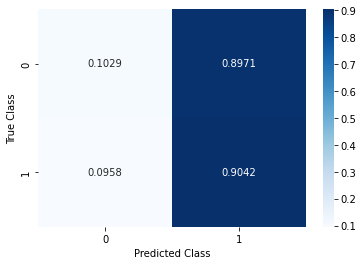

In [ ]:
import seaborn as sns

cm = np.sum(best_cm, axis=0)
normalized_cm = cm / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(normalized_cm, annot=True, fmt=".4f", cmap='Blues')
plt.ylabel('True Class')
plt.xlabel('Predicted Class')
plt.show()